In [1]:
#from tcn import TCN
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense  , Activation
from sklearn.metrics import mean_squared_error, r2_score
import math
from tqdm.notebook import tqdm
import random
import time as t
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.ensemble import GradientBoostingRegressor
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
# Set the style to whitegrid
plt.style.use('seaborn-whitegrid')
plt.style.library['seaborn-whitegrid']
plt.style.use("seaborn-v0_8-whitegrid")


2024-06-24 08:47:43.050751: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 08:47:43.050866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 08:47:43.185622: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [3]:
# Setting seeds value for results reproducability
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [4]:
# Assuming your DataFrame is named 'df' path: /kaggle/working/Solar-Irradiance-Forecasting/Solar Irradiance Dataset Karachi/2017.csv
desired_starting_row = 3

path2017 = "/kaggle/input/solar-irradiance-dataset-karachi/2017.csv"
path2018 = "/kaggle/input/solar-irradiance-dataset-karachi/2018.csv"
path2019 = "/kaggle/input/solar-irradiance-dataset-karachi/2019.csv"

df2017 = pd.read_csv(path2017, skiprows=desired_starting_row - 1)
df2018 = pd.read_csv(path2018, skiprows=desired_starting_row - 1)
df2019 = pd.read_csv(path2019, skiprows=desired_starting_row - 1)



In [5]:
# merging three csv files 
df = pd.concat([df2017 , df2018 , df2019], ignore_index=True) 

In [6]:
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])

In [7]:
df.head(-10)

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,date
0,2017,1,1,0,0,17.6,0,0,0,0,...,0,0.241,72.52,120.12,0.17,1014,1.3,52,2.3,2017-01-01 00:00:00
1,2017,1,1,0,15,17.6,0,0,0,0,...,0,0.241,72.52,116.82,0.17,1014,1.3,53,2.3,2017-01-01 00:15:00
2,2017,1,1,0,30,17.5,0,0,0,0,...,0,0.241,72.98,113.53,0.17,1014,1.3,54,2.4,2017-01-01 00:30:00
3,2017,1,1,0,45,17.4,0,0,0,0,...,0,0.241,67.37,110.26,0.17,1014,1.3,56,2.5,2017-01-01 00:45:00
4,2017,1,1,1,0,17.3,0,0,0,0,...,0,0.241,67.86,107.02,0.17,1015,1.3,57,2.5,2017-01-01 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105105,2019,12,31,20,15,13.4,0,0,0,0,...,0,0.277,51.87,170.68,0.17,1017,0.9,65,3.7,2019-12-31 20:15:00
105106,2019,12,31,20,30,13.3,0,0,0,0,...,0,0.277,52.21,167.30,0.17,1017,0.9,65,3.7,2019-12-31 20:30:00
105107,2019,12,31,20,45,13.2,0,0,0,0,...,0,0.278,52.38,163.91,0.17,1017,0.9,64,3.8,2019-12-31 20:45:00
105108,2019,12,31,21,0,13.1,0,0,0,0,...,0,0.278,52.72,160.51,0.17,1017,0.9,63,3.9,2019-12-31 21:00:00


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105120 entries, 0 to 105119
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Year                105120 non-null  int64         
 1   Month               105120 non-null  int64         
 2   Day                 105120 non-null  int64         
 3   Hour                105120 non-null  int64         
 4   Minute              105120 non-null  int64         
 5   Temperature         105120 non-null  float64       
 6   Clearsky DHI        105120 non-null  int64         
 7   Clearsky DNI        105120 non-null  int64         
 8   Clearsky GHI        105120 non-null  int64         
 9   Cloud Type          105120 non-null  int64         
 10  Dew Point           105120 non-null  float64       
 11  DHI                 105120 non-null  int64         
 12  DNI                 105120 non-null  int64         
 13  Fill Flag           105120 no

In [9]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Year,105120.0,2018.0,2017.0,2017.0,2018.0,2019.0,2019.0,0.8165
Month,105120.0,6.526027,1.0,4.0,7.0,10.0,12.0,3.447868
Day,105120.0,15.720548,1.0,8.0,16.0,23.0,31.0,8.796289
Hour,105120.0,11.5,0.0,5.75,11.5,17.25,23.0,6.922219
Minute,105120.0,22.5,0.0,11.25,22.5,33.75,45.0,16.77059
Temperature,105120.0,26.56804,11.1,23.4,27.2,30.0,40.1,4.880504
Clearsky DHI,105120.0,101.339717,0.0,0.0,0.0,195.0,603.0,128.76109
Clearsky DNI,105120.0,223.957515,0.0,0.0,0.0,487.0,957.0,280.52098
Clearsky GHI,105120.0,251.943731,0.0,0.0,0.0,546.0,1039.0,325.494811
Cloud Type,105120.0,1.332544,0.0,0.0,0.0,2.0,12.0,2.373412


In [10]:
count = (df['GHI'] == 0).sum()
count

52986

In [11]:
def filter_time_range(df):
    filtered_df = df.copy()

    # Convert the 'datetime' column to datetime type
    filtered_df['date'] = pd.to_datetime(filtered_df['date'], format="%d-%m-%y %H:%M")

    # Filter the DataFrame based on time range
    filtered_df = filtered_df[
         (filtered_df['date'].dt.hour <= 19) &
        (filtered_df['date'].dt.hour >= 5)
    ]

    return filtered_df

In [12]:
df = filter_time_range(df)

In [13]:
count = (df['GHI'] == 0).sum()
count

28004

In [14]:
df.set_index('date', inplace=True)

In [15]:
df = df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute','Cloud Type', 'Ozone','Solar Zenith Angle', 'Surface Albedo',
                    'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'DHI', 'DNI', 'Fill Flag'], axis = 1)
df.head()

,Temperature,Dew Point,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed
date,,,,,,,,
2017-01-01 05:00:00,23.1,6.7,406,34.73,1017,1.2,74,3.8
2017-01-01 05:15:00,23.7,6.7,443,33.50,1017,1.2,74,3.7
2017-01-01 05:30:00,24.2,6.7,478,32.51,1017,1.2,75,3.6
2017-01-01 05:45:00,24.7,5.8,497,29.65,1017,1.2,76,3.6
2017-01-01 06:00:00,25.2,5.8,525,28.78,1017,1.2,77,3.5


In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,65700.0,27.804886,4.519130,13.6,25.00,28.100,31.2000,40.1
Dew Point,65700.0,18.270802,7.600011,-10.6,12.80,20.800,24.8000,28.4
GHI,65700.0,302.771081,337.444032,0.0,0.00,115.000,634.0000,1039.0
Relative Humidity,65700.0,60.095529,21.503727,9.1,42.12,61.485,78.7325,100.0
Pressure,65700.0,1008.047519,6.667646,991.0,1002.00,1008.000,1013.0000,1026.0
Precipitable Water,65700.0,2.826100,1.662767,0.3,1.60,2.400,3.9000,8.0
Wind Direction,65700.0,222.492572,70.061426,0.0,223.00,242.000,257.0000,360.0
Wind Speed,65700.0,3.620068,1.698306,0.2,2.30,3.400,4.8000,10.0


<Axes: >

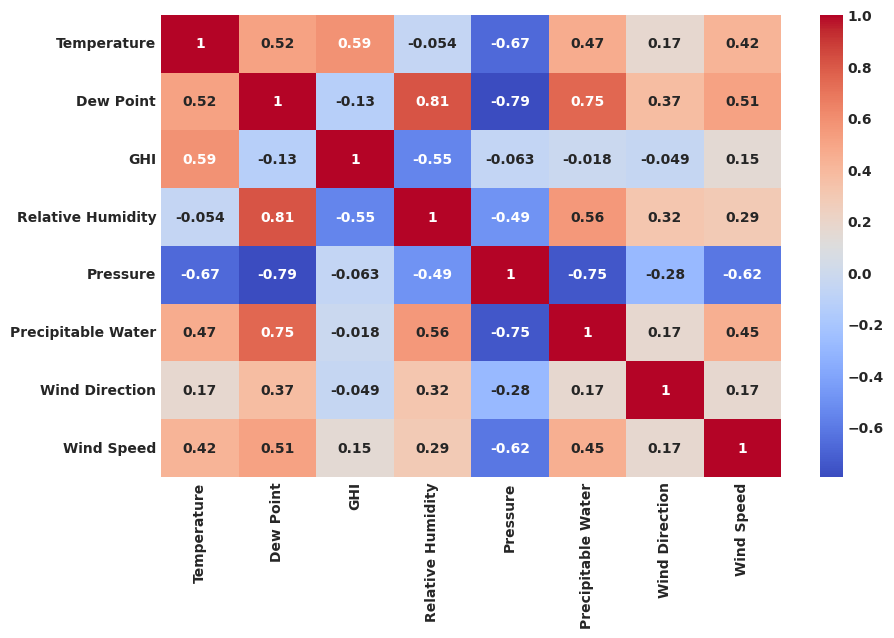

In [17]:
from matplotlib import rcParams

rcParams['font.weight'] = 'bold'
plt.figure(figsize=(10,6))

sns.heatmap(df.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

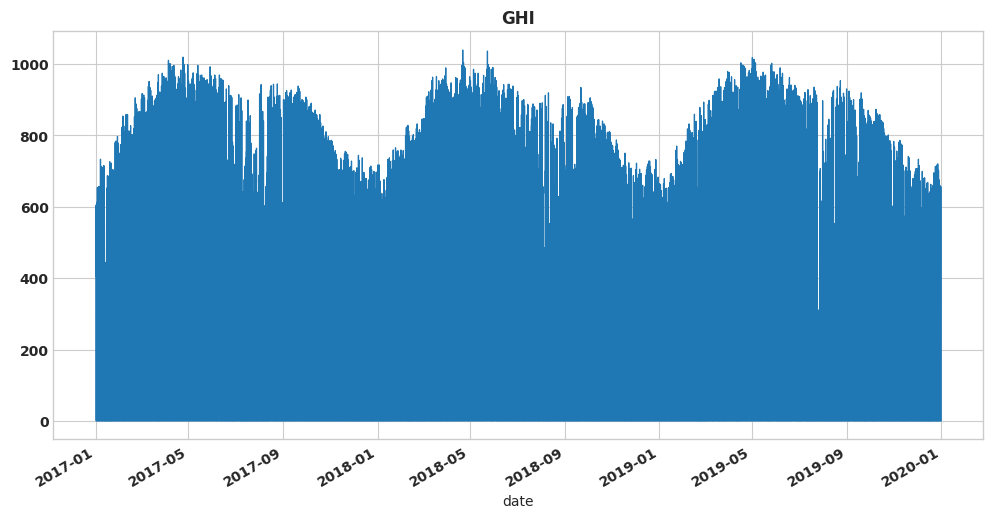

In [18]:
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")
plt.title("GHI" ,  weight='bold')
df['GHI'].plot(linewidth=0.9 , use_index=True);

In [19]:
columns = df.columns.tolist()
columns[2], columns[-1] = columns[-1], columns[2]
df = df[columns]
df.head()

,Temperature,Dew Point,Wind Speed,Relative Humidity,Pressure,Precipitable Water,Wind Direction,GHI
date,,,,,,,,
2017-01-01 05:00:00,23.1,6.7,3.8,34.73,1017,1.2,74,406
2017-01-01 05:15:00,23.7,6.7,3.7,33.50,1017,1.2,74,443
2017-01-01 05:30:00,24.2,6.7,3.6,32.51,1017,1.2,75,478
2017-01-01 05:45:00,24.7,5.8,3.6,29.65,1017,1.2,76,497
2017-01-01 06:00:00,25.2,5.8,3.5,28.78,1017,1.2,77,525


In [20]:
X = df.drop('GHI' , axis=1)

In [21]:
X.head()

,Temperature,Dew Point,Wind Speed,Relative Humidity,Pressure,Precipitable Water,Wind Direction
date,,,,,,,
2017-01-01 05:00:00,23.1,6.7,3.8,34.73,1017,1.2,74
2017-01-01 05:15:00,23.7,6.7,3.7,33.50,1017,1.2,74
2017-01-01 05:30:00,24.2,6.7,3.6,32.51,1017,1.2,75
2017-01-01 05:45:00,24.7,5.8,3.6,29.65,1017,1.2,76
2017-01-01 06:00:00,25.2,5.8,3.5,28.78,1017,1.2,77


In [22]:
y = df['GHI']


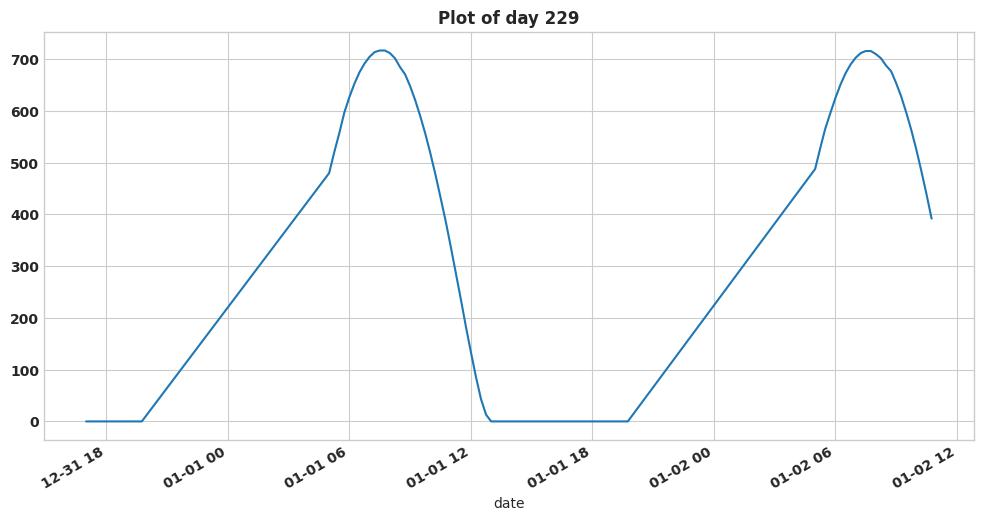

In [23]:
random_day = random.randint(1, 1095)
target_plot = df['GHI'][(random_day-1)*96:(random_day*96)]
plt.figure(figsize=(12,6))
target_plot.plot()
plt.title(str(f"Plot of day {random_day}") ,  weight='bold')
plt.show()

In [24]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head(10)                     # this normalizes the data in between range [0, 1]

,Temperature,Dew Point,Wind Speed,Relative Humidity,Pressure,Precipitable Water,Wind Direction
0,0.358491,0.443590,0.367347,0.281958,0.742857,0.116883,0.205556
1,0.381132,0.443590,0.357143,0.268427,0.742857,0.116883,0.205556
2,0.400000,0.443590,0.346939,0.257536,0.742857,0.116883,0.208333
3,0.418868,0.420513,0.346939,0.226073,0.742857,0.116883,0.211111
4,0.437736,0.420513,0.336735,0.216502,0.742857,0.116883,0.213889
5,0.449057,0.420513,0.316327,0.211001,0.742857,0.116883,0.216667
6,0.464151,0.420513,0.306122,0.203410,0.714286,0.116883,0.219444
7,0.475472,0.407692,0.295918,0.187569,0.714286,0.116883,0.222222
8,0.486792,0.407692,0.275510,0.182508,0.714286,0.116883,0.225000
9,0.494340,0.407692,0.265306,0.178878,0.685714,0.116883,0.230556


In [25]:
X.shape

(65700, 7)

In [26]:
per_day_readings = 4 * 24                  # readings in one hour x total number of hours in a day
days = 3                                   # this variable defines our window length
window_length = days * per_day_readings    # we want our model to look back at the data of 3 days
horizon = 1                                # and then predict the next 15th minute reading

In [27]:
df = X.values                  # converting dataframe to numpy arrays
stride = 1
x = []
y = []
for i in tqdm(range(0, len(df) - window_length, stride)):
    x.append(df[i:window_length+i, : ])    # GHI included but its past values only
    y.append(df[window_length+i,-1])       # next GHI value as our target which is to be predicted by the model

  0%|          | 0/65412 [00:00<?, ?it/s]

In [28]:
x = np.array(x)                            # converting our features to numpy array
y = np.array(y)                            # converting our target to numpy array
print(x.shape)                             # printing our total feature data's shape
print(y.shape)                             # printing our target data's shape

(65412, 288, 7)
(65412,)


In [29]:
# splitting our dataset into two parts one will be training set and the other will be testing set
# Lets store last 5 days as our test set
testing_days = 10
per_day_readings = 4 * 24                  # readings in one hour x total number of hours in a day
days = 3                                   # this variable defines our window length
window_length = days * per_day_readings    # we want our model to look back at the data of 3 days
horizon = 1                                # and then predict the next 15th minute reading


x_train = x[:-per_day_readings*testing_days]
y_train = y[:-per_day_readings*testing_days]
x_test  = x[len(y) - per_day_readings*testing_days:]
y_test  = y[len(y) - per_day_readings*testing_days:]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(64452, 288, 7)
(64452,)
(960, 288, 7)
(960,)


In [30]:
set_epochs = 300

# **CNN_LSTM_MLP**
Hourly stepwise forecasting for solar irradiance using integrated hybrid models CNN-LSTM-MLP combined with error correction and VMD

In [31]:
# Define your CNN-LSTM-MLP model
from tensorflow.keras.layers import Convolution1D , Flatten , Conv1D , MaxPooling1D , LSTM , BatchNormalization , Dropout


cnn_lstm_mlp = Sequential()

# Convolutional layer
cnn_lstm_mlp.add(Conv1D(64, kernel_size=3, activation='relu',padding='same', input_shape=(288,7))) #4, 288
cnn_lstm_mlp.add(Conv1D(32, kernel_size=3, activation='relu'))
cnn_lstm_mlp.add(Dropout(0.3))
cnn_lstm_mlp.add(MaxPooling1D(pool_size=1))

# LSTM layer
cnn_lstm_mlp.add(LSTM(64, return_sequences=True))
cnn_lstm_mlp.add(LSTM(64))

# Flatten the output before MLP
cnn_lstm_mlp.add(Flatten())

# MLP layer
cnn_lstm_mlp.add(Dense(64, activation='relu'))
#cnn_lstm_mlp.add(Dense(64, activation='relu'))
cnn_lstm_mlp.add(Dense(32, activation='relu'))

#cnn_lstm_mlp.add(BatchNormalization())
cnn_lstm_mlp.add(Dense(1, activation='sigmoid'))  # Adjust output layer based on your task

# Compile the model
# Compile the model with the optimizer and learning rate
# Define the learning rate
learning_rate = 0.001

cnn_lstm_mlp.compile(loss='mae',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
# Print the model summary
cnn_lstm_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 288, 64)        │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 286, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 286, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 286, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 286, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,713 (280.13 KB)

 Trainable params: 71,713 (280.13 KB)

 Non-trainable params: 0 (0.00 B)

# **CNN_II model (Deep learning based long-term global solar irradiance and temperature forecasting using time series with multi-step multivariate output)**

In [32]:
from tensorflow.keras.layers import Convolution1D , Flatten

modelCNN = Sequential()

modelCNN.add(Convolution1D(50,
                 3,
                 activation='relu',
                 input_shape=(288, 7)))

modelCNN.add(Flatten())
modelCNN.add(Dense(50, activation='tanh'))  # Hidden layer
modelCNN.add(Dense(1, activation='linear'))  # Output layer

modelCNN.summary()


# Define the learning rate
learning_rate = 0.001

# Compile the model with the optimizer and learning rate
modelCNN.compile(loss='mae',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 286, 50)        │         1,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14300)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │       715,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 716,201 (2.73 MB)

 Trainable params: 716,201 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

# **MLP model (Short-term solar irradiance forecasting in streaming with deep learning)**

In [33]:
"""Creates Multi Layer Perceptron (MLP) model."""
import tensorflow as tf

def MLP(
    input_shape,
    output_size,
    loss,
    optimizer,
    hidden_layers=[32, 16, 8],
    dropout=0.0,
    activation="linear",
    out_activation="linear",
):
   
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Flatten()(inputs)  # Convert the 2d input in a 1d array

    for hidden_units in hidden_layers:
        x = tf.keras.layers.Dense(hidden_units, activation=activation)(x)
        x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(output_size, activation=out_activation)(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=optimizer, loss='mae' , metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

# Define the learning rate
learning_rate = 0.001

modelMLP = MLP(input_shape=(288, 7) ,output_size=1 , loss = 'mae' , optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate))


modelMLP.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 288, 7)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2016)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │        64,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,217 (254.75 KB)

 Trainable params: 65,217 (254.75 KB)

 Non-trainable params: 0 (0.00 B)

# **LSTM model (Solar Irradiance Forecasting Using Deep Learning Techniques)**

In [34]:
# LSTM Model
modelLSTM = tf.keras.Sequential([
    keras.layers.LSTM(64, input_shape=(288, 7), return_sequences=True),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dense(1, activation="sigmoid")
])
# Define the learning rate
learning_rate = 0.001

# Compile the model with the optimizer and learning rate
modelLSTM.compile(loss='mae',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

modelLSTM.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 288, 64)        │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,521 (201.25 KB)

 Trainable params: 51,521 (201.25 KB)

 Non-trainable params: 0 (0.00 B)

# **CNN-LSTM Sliding window approach with first-order differencing for very short-term solar irradiance forecasting using deep learning models**

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Dense, LSTM, Reshape

input_shape = (288, 7)  

# Define CNN-LSTM model
model_cnn_lstm = Sequential()

# Input layer
model_cnn_lstm.add(Input(shape=input_shape))

# 1D CNN layer 1
model_cnn_lstm.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))
model_cnn_lstm.add(Dropout(0.25))

# 1D CNN layer 2
model_cnn_lstm.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))
model_cnn_lstm.add(Dropout(0.25))

# Flatten before passing to LSTM layers
model_cnn_lstm.add(tf.keras.layers.Flatten())

# Dense layers
model_cnn_lstm.add(Dense(256, activation='relu'))
model_cnn_lstm.add(Dense(128, activation='relu'))
model_cnn_lstm.add(Dropout(0.5))

# Reshape to add timestep dimension
model_cnn_lstm.add(Reshape((1, -1)))

# LSTM layer 1
model_cnn_lstm.add(LSTM(64, return_sequences=True))
model_cnn_lstm.add(Dropout(0.5))

# LSTM layer 2
model_cnn_lstm.add(LSTM(32))
model_cnn_lstm.add(Dropout(0.5))

# Dense layers
model_cnn_lstm.add(Dense(64, activation='relu'))
model_cnn_lstm.add(Dense(32, activation='relu'))

# Output layer
model_cnn_lstm.add(Dense(units=1, activation='sigmoid'))  # Adjust 'num_classes' based on your task

learning_rate = 0.001

model_cnn_lstm.compile(loss='mae',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
# Print the model summary
model_cnn_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 288, 64)        │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 144, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 144, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 144, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,484,609 (9.48 MB)

 Trainable params: 2,484,609 (9.48 MB)

 Non-trainable params: 0 (0.00 B)

# **CNN Attention LSTM**
# **Prediction of solar irradiance using convolutional neural network and attention mechanism-based long short-term memory network based on similar day analysis and an attention mechanism**

In [36]:
from keras import layers
class Attention(layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)
        self.V = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        query = tf.matmul(inputs, self.W) + self.b
        query = tf.nn.tanh(query)
        score = tf.reduce_sum(tf.multiply(query, self.V), axis=2)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(tf.multiply(inputs, tf.expand_dims(attention_weights, axis=-1)), axis=1)
        return context_vector

In [37]:
inputs_1 = layers.Input(shape=(288, 7))
x = layers.LSTM(64, return_sequences=True)(inputs_1)
x = Attention(units=32)(x)

x = Conv1D(128, 5)(inputs_1)
x = Activation('relu')(x)

x = Conv1D(64, 5)(x)
x = Activation('relu')(x)

x = Conv1D(32, 5)(x)
x = Activation('relu')(x)

x = Flatten()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

outputs = Dense(1, activation='linear')(x)

model_cnn_a_lstm = tf.keras.models.Model(inputs=inputs_1, outputs=outputs)

In [38]:
model_cnn_a_lstm.compile(loss='mae',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
# Print the model summary
model_cnn_a_lstm.summary()

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 288, 7)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 284, 128)       │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 284, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 280, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 280, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 276, 32)        │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 276, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8832)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │     2,261,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,351,713 (8.97 MB)

 Trainable params: 2,350,945 (8.97 MB)

 Non-trainable params: 768 (3.00 KB)

# **Attention / Attention mechanism for developing wind speed and solar irradiance forecasting models**

In [39]:
inputs_1 = layers.Input(shape=(288, 7))
x = layers.LSTM(64, return_sequences=True)(inputs_1)
x = Attention(units=32)(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='linear')(x)
model_attention = tf.keras.models.Model(inputs=inputs_1, outputs=outputs)

In [40]:
model_attention.compile(loss='mae',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
# Print the model summary
model_attention.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 288, 7)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 288, 64)        │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,929 (113.00 KB)

 Trainable params: 28,929 (113.00 KB)

 Non-trainable params: 0 (0.00 B)

# **TCN / Solar Irradiance Forecasting Using Deep Learning Techniques**

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Add, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

# Define the input shape
input_shape=(288 , 7)  
inputs = Input(shape=input_shape)

# Conv-1D Layer
conv1d_layer = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)

# ResNet Dilated Block
def resnet_dilated_block(x):
    dilation_rates = [1, 2, 4]
    for dilation_rate in dilation_rates:
        shortcut = x
        x = Conv1D(filters=64, kernel_size=3, padding='same', dilation_rate=dilation_rate, activation='relu')(x)
        x = Conv1D(filters=64, kernel_size=3, padding='same', dilation_rate=dilation_rate)(x)
        x = Add()([x, shortcut])
        x = tf.keras.layers.Activation('relu')(x)
    return x

resnet_block = resnet_dilated_block(conv1d_layer)

# Lambda Layer to add skip connection
lambda_layer = Lambda(lambda x: x[0] + x[1])([resnet_block, conv1d_layer])

# Dense Block
dense_block = Flatten()(lambda_layer)
dense_block = Dense(units=128, activation='relu')(dense_block)

# Prediction Layer
output = Dense(units=1, activation='linear')(dense_block)  

# Define the model
model_tcn = Model(inputs=inputs, outputs=output)

In [42]:
model_tcn.compile(loss='mae',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
# Print the model summary
model_tcn.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 288, 7)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 288, 64)   │      1,408 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 288, 64)   │     12,352 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 288, 64)   │     12,352 │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 288, 64)   │          0 │ conv1d_10[0][0],  │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 288, 64)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 288, 64)   │     12,352 │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 288, 64)   │     12,352 │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 288, 64)   │          0 │ conv1d_12[0][0],  │
│                     │                   │            │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 288, 64)   │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 288, 64)   │     12,352 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 288, 64)   │     12,352 │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 288, 64)   │          0 │ conv1d_14[0][0],  │
│                     │                   │            │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 288, 64)   │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 288, 64)   │          0 │ activation_7[0][… │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 18432)     │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 128)       │  2,359,424 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 1)         │        129 │ dense_21[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,435,073 (9.29 MB)

 Trainable params: 2,435,073 (9.29 MB)

 Non-trainable params: 0 (0.00 B)

# **Biderction LSTM**

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, Flatten

# Define the CNN-Bidirectional LSTM model architecture
def create_cnn_bilstm_model(input_shape):
    model = Sequential()

    # Convolutional Neural Network (CNN) layers
    model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=2))
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))
    
    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))

    return model

# Example usage
input_shape = (288, 7)  # Adjust based on your actual input shape
model_esn = create_cnn_bilstm_model(input_shape)
model_esn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])



In [44]:
# Define the learning rate
learning_rate = 0.001

# Compile the model with the optimizer and learning rate
model_esn.compile(loss='mae',
              optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [45]:
model_esn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 288, 128)       │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 288, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 288, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 144, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 144, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,097 (1016.00 KB)

 Trainable params: 260,097 (1016.00 KB)

 Non-trainable params: 0 (0.00 B)

# **Proposed**

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Flatten, MaxPooling1D
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define the CNN-LSTM model architecture
def create_cnn_lstm_knn(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=1))
    model.add(LSTM(64, return_sequences=True)) 
    model.add(LSTM(64)) 
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))
    return model

input_shape = (288, 7)  # Example input shape

cnn_lstm_knn = create_cnn_lstm_knn(input_shape)

# Define the learning rate
learning_rate = 0.001

# Compile the model with the optimizer and learning rate
cnn_lstm_knn.compile(loss='mae',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [47]:
# Ensure the model is built by calling it with dummy data
dummy_input = np.zeros((1, *input_shape))
_ = cnn_lstm_knn(dummy_input)

In [48]:
cnn_lstm_knn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_17 (Conv1D)              │ (None, 288, 128)       │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 288, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 288, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 288, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 288, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,313 (552.00 KB)

 Trainable params: 141,313 (552.00 KB)

 Non-trainable params: 0 (0.00 B)

# **Fit Models**

In [49]:
import time as t
time1 = t.time()
print('Train...')
epochs = set_epochs
history_cnn_lstm_mlp = cnn_lstm_mlp.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2 , 
                    verbose=1, batch_size=1000)
time_cnn_lstm_mlp = t.time() - time1
print(f"Total time to train {epochs} of CNN_LSTM_MLP model is {time_cnn_lstm_mlp}")

Train...
Epoch 1/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 0.1289 - root_mean_squared_error: 0.1877 - val_loss: 0.0908 - val_root_mean_squared_error: 0.1549
Epoch 2/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0647 - root_mean_squared_error: 0.1223 - val_loss: 0.0403 - val_root_mean_squared_error: 0.0867
Epoch 3/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0405 - root_mean_squared_error: 0.0836 - val_loss: 0.0346 - val_root_mean_squared_error: 0.0696
Epoch 4/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0338 - root_mean_squared_error: 0.0685 - val_loss: 0.0286 - val_root_mean_squared_error: 0.0605
Epoch 5/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0309 - root_mean_squared_error: 0.0626 - val_loss: 0.0252 - val_root_mean_squared_error: 0.0550
Epoch 6/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0280 - root_mean_squared_error: 0.0580 - val_loss: 0.0239 - val_root_mean_squared_error: 0.0520
Epoch 7/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s

In [50]:
time1 = t.time()
print('Train...')
epochs = set_epochs
historyCNN = modelCNN.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2 , 
                    verbose=1, batch_size=8192)
timeCNN = t.time() - time1
print(f"Total time to train {epochs} of CNN model is {timeCNN}")

Train...
Epoch 1/300


2024-06-24 09:14:31.591208: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng34{k2=1,k4=3,k5=1,k6=0,k7=0} for conv (f32[7,50,1,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,8192,1,288]{3,2,1,0}, f32[50,8192,1,286]{3,2,1,0}), window={size=1x286}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-24 09:14:31.665017: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.073916389s
Trying algorithm eng34{k2=1,k4=3,k5=1,k6=0,k7=0} for conv (f32[7,50,1,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,8192,1,288]{3,2,1,0}, f32[50,8192,1,286]{3,2,1,0}), window={size=1x286}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-24 09:14:33.630360:

7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 4.4671 - root_mean_squared_error: 4.9666 - val_loss: 4.6860 - val_root_mean_squared_error: 4.6898
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 3.3393 - root_mean_squared_error: 3.5395 - val_loss: 0.2090 - val_root_mean_squared_error: 0.2400
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.3805 - root_mean_squared_error: 0.4201 - val_loss: 0.1353 - val_root_mean_squared_error: 0.1860
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 0.1493 - root_mean_squared_error: 0.1998 - val_loss: 0.2161 - val_root_mean_squared_error: 0.2746
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.1558 - root_mean_squared_error: 0.2217 - val_loss: 0.1265 - val_root_mean_squared_error: 0.1998
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.1201 - root_mean_squared_error: 0.1781 - val_loss: 0.1302 - val_root_mean_squared_error: 0.1933
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.1181 - root

In [51]:
time1 = t.time()
print('Train...')
epochs = set_epochs
historyLSTM = modelLSTM.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2,
                    verbose=1, batch_size=8192)
timeLSTM = t.time() - time1
print(f"Total time to train {epochs} of LSTM model is {timeLSTM}")

Train...
Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 629ms/step - loss: 0.1477 - root_mean_squared_error: 0.1937 - val_loss: 0.1405 - val_root_mean_squared_error: 0.2208
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 548ms/step - loss: 0.1112 - root_mean_squared_error: 0.1782 - val_loss: 0.1251 - val_root_mean_squared_error: 0.2050
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 546ms/step - loss: 0.1047 - root_mean_squared_error: 0.1770 - val_loss: 0.1247 - val_root_mean_squared_error: 0.2082
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 545ms/step - loss: 0.1001 - root_mean_squared_error: 0.1749 - val_loss: 0.1214 - val_root_mean_squared_error: 0.2042
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 548ms/step - loss: 0.0957 - root_mean_squared_error: 0.1745 - val_loss: 0.1129 - val_root_mean_squared_error: 0.1893
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 546ms/step - loss: 0.0888 - root_mean_squared_error: 0.1641 - val_loss: 0.0957 - val_root_mean_squared_error: 0.1639
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 549ms/ste

In [52]:
time1 = t.time()
print('Train...')
epochs = set_epochs
historyMLP = modelMLP.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2 , 
                    verbose=1, batch_size=8192)
timeMLP = t.time() - time1
print(f"Total time to train {epochs} of MLP model  is {timeMLP}")

Train...
Epoch 1/300
4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.8183 - root_mean_squared_error: 4.6228

W0000 00:00:1719222212.646748      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - loss: 3.8433 - root_mean_squared_error: 4.7339 - val_loss: 0.4871 - val_root_mean_squared_error: 0.5548
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4999 - root_mean_squared_error: 1.7539 - val_loss: 1.6155 - val_root_mean_squared_error: 1.6420
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.0672 - root_mean_squared_error: 1.1737 - val_loss: 1.3730 - val_root_mean_squared_error: 1.3999
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.9616 - root_mean_squared_error: 1.0501 - val_loss: 0.7070 - val_root_mean_squared_error: 0.7458
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.7089 - root_mean_squared_error: 0.7846 - val_loss: 0.2590 - val_root_mean_squared_error: 0.3030
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.5140 - root_mean_squared_error: 0.5971 - val_loss: 0.6834 - val_root_mean_squared_error: 0.7300
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.5383 - root_mea

In [53]:
time1 = t.time()
print('Train...')
epochs = set_epochs
history_cnn_lstm = model_cnn_lstm.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2 , 
                    verbose=1, batch_size=8192)
time_cnn_lstm = t.time() - time1
print(f"Total time to train {epochs} of CNN LSTM model  is {time_cnn_lstm}")

Train...
Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 476ms/step - loss: 0.2035 - root_mean_squared_error: 0.2226 - val_loss: 0.1702 - val_root_mean_squared_error: 0.2079
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - loss: 0.1631 - root_mean_squared_error: 0.1983 - val_loss: 0.1333 - val_root_mean_squared_error: 0.2217
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - loss: 0.1239 - root_mean_squared_error: 0.1941 - val_loss: 0.1616 - val_root_mean_squared_error: 0.2481
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.1225 - root_mean_squared_error: 0.1989 - val_loss: 0.1316 - val_root_mean_squared_error: 0.2167
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - loss: 0.1180 - root_mean_squared_error: 0.1886 - val_loss: 0.1316 - val_root_mean_squared_error: 0.2151
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 0.1153 - root_mean_squared_error: 0.1903 - val_loss: 0.1321 - val_root_mean_squared_error: 0.2191
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/ste

In [54]:
import time as t
time1 = t.time()
print('Train...')
epochs = set_epochs
history_cnn_a_lstm = model_cnn_a_lstm.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2 , 
                    verbose=1, batch_size=1000)
time_cnn_a_lstm = t.time() - time1
print(f"Total time to train {epochs} of CNN_Attention_LSTM model is {time_cnn_a_lstm}")

Train...
Epoch 1/300
 2/52 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 1.5357 - root_mean_squared_error: 1.8849 

W0000 00:00:1719222887.317960      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719222887.319806      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.6030 - root_mean_squared_error: 1.0331

W0000 00:00:1719222897.221777      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719222898.052348      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step - loss: 0.5967 - root_mean_squared_error: 1.0255 - val_loss: 0.5860 - val_root_mean_squared_error: 0.6476
Epoch 2/300
 1/52 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.0885 - root_mean_squared_error: 0.1350

W0000 00:00:1719222899.199237      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0717 - root_mean_squared_error: 0.1231 - val_loss: 0.3758 - val_root_mean_squared_error: 0.4381
Epoch 3/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0543 - root_mean_squared_error: 0.1034 - val_loss: 0.1429 - val_root_mean_squared_error: 0.1820
Epoch 4/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0518 - root_mean_squared_error: 0.0951 - val_loss: 0.1735 - val_root_mean_squared_error: 0.2117
Epoch 5/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0448 - root_mean_squared_error: 0.0846 - val_loss: 0.1252 - val_root_mean_squared_error: 0.1574
Epoch 6/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0453 - root_mean_squared_error: 0.0797 - val_loss: 0.2525 - val_root_mean_squared_error: 0.2870
Epoch 7/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0397 - root_mean_squared_error: 0.0726 - val_loss: 0.2114 - val_root_mean_squared_error: 0.2282
Epoch 8/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.03

In [55]:
import time as t
time1 = t.time()
print('Train...')
epochs = set_epochs
history_attention = model_attention.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2 , 
                    verbose=1, batch_size=1000)
time_attention = t.time() - time1
print(f"Total time to train {epochs} of Attention model is {time_attention}")

Train...
Epoch 1/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.2216 - root_mean_squared_error: 0.2890 - val_loss: 0.1259 - val_root_mean_squared_error: 0.2065
Epoch 2/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.1050 - root_mean_squared_error: 0.1801 - val_loss: 0.1211 - val_root_mean_squared_error: 0.1957
Epoch 3/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.1034 - root_mean_squared_error: 0.1757 - val_loss: 0.1170 - val_root_mean_squared_error: 0.1944
Epoch 4/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.1026 - root_mean_squared_error: 0.1762 - val_loss: 0.1172 - val_root_mean_squared_error: 0.1950
Epoch 5/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.1017 - root_mean_squared_error: 0.1760 - val_loss: 0.1172 - val_root_mean_squared_error: 0.1959
Epoch 6/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.1012 - root_mean_squared_error: 0.1763 - val_loss: 0.1175 - val_root_mean_squared_error: 0.1973
Epoch 7/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 5

In [56]:
import time as t
time1 = t.time()
print('Train...')
epochs = set_epochs
history_tcn = model_tcn.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2 , 
                    verbose=1, batch_size=1000)
time_tcn = t.time() - time1
print(f"Total time to train {epochs} of TCN model is {time_tcn}")

Train...
Epoch 1/300
 1/52 ━━━━━━━━━━━━━━━━━━━━ 13:12 16s/step - loss: 0.7665 - root_mean_squared_error: 0.7916

W0000 00:00:1719225303.879329      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719225303.883388      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 3.2664 - root_mean_squared_error: 7.2727

W0000 00:00:1719225318.409073      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719225319.438698      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 341ms/step - loss: 3.2253 - root_mean_squared_error: 7.2188 - val_loss: 0.1097 - val_root_mean_squared_error: 0.1765
Epoch 2/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - loss: 0.0771 - root_mean_squared_error: 0.1373 - val_loss: 0.0487 - val_root_mean_squared_error: 0.0946
Epoch 3/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - loss: 0.0391 - root_mean_squared_error: 0.0817 - val_loss: 0.0299 - val_root_mean_squared_error: 0.0660
Epoch 4/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - loss: 0.0275 - root_mean_squared_error: 0.0622 - val_loss: 0.0258 - val_root_mean_squared_error: 0.0573
Epoch 5/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - loss: 0.0236 - root_mean_squared_error: 0.0551 - val_loss: 0.0261 - val_root_mean_squared_error: 0.0548
Epoch 6/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - loss: 0.0229 - root_mean_squared_error: 0.0526 - val_loss: 0.0243 - val_root_mean_squared_error: 0.0520
Epoch 7/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - lo

In [57]:
import time as t
time1 = t.time()
print('Train...')
epochs = set_epochs
history_esn = model_esn.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2 , 
                    verbose=1, batch_size=1000)
time_esn = t.time() - time1
print(f"Total time to train {epochs} of TCN model is {time_esn}")

Train...
Epoch 1/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 0.1930 - root_mean_squared_error: 0.2665 - val_loss: 0.0879 - val_root_mean_squared_error: 0.1211
Epoch 2/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - loss: 0.0479 - root_mean_squared_error: 0.0992 - val_loss: 0.0724 - val_root_mean_squared_error: 0.0981
Epoch 3/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - loss: 0.0365 - root_mean_squared_error: 0.0792 - val_loss: 0.0927 - val_root_mean_squared_error: 0.1100
Epoch 4/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - loss: 0.0296 - root_mean_squared_error: 0.0690 - val_loss: 0.0840 - val_root_mean_squared_error: 0.1001
Epoch 5/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - loss: 0.0261 - root_mean_squared_error: 0.0623 - val_loss: 0.0855 - val_root_mean_squared_error: 0.0998
Epoch 6/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - loss: 0.0246 - root_mean_squared_error: 0.0578 - val_loss: 0.0887 - val_root_mean_squared_error: 0.1020
Epoch 7/300
52/52 ━━━━━━━━━━━━━━━━━

In [58]:
x_train.shape

(64452, 288, 7)

In [59]:
y_train.shape

(64452,)

In [60]:
import time as t
time1 = t.time()
print('Train...')
epochs = set_epochs
history_cnn_lstm_knn = cnn_lstm_knn.fit(x_train, y_train,
                    epochs=epochs,
                    validation_split=0.2 , 
                    verbose=1, batch_size=1000)
time_cnn_lstm_knn = t.time() - time1
print(f"Total time to train {epochs} of CNN_LSTM_MLP_KNN model is {time_cnn_lstm_knn}")

Train...
Epoch 1/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - loss: 0.2737 - root_mean_squared_error: 0.3603 - val_loss: 0.0572 - val_root_mean_squared_error: 0.1132
Epoch 2/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.0559 - root_mean_squared_error: 0.1096 - val_loss: 0.0416 - val_root_mean_squared_error: 0.0893
Epoch 3/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.0390 - root_mean_squared_error: 0.0854 - val_loss: 0.0267 - val_root_mean_squared_error: 0.0736
Epoch 4/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.0336 - root_mean_squared_error: 0.0745 - val_loss: 0.0257 - val_root_mean_squared_error: 0.0659
Epoch 5/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.0290 - root_mean_squared_error: 0.0664 - val_loss: 0.0242 - val_root_mean_squared_error: 0.0592
Epoch 6/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.0259 - root_mean_squared_error: 0.0601 - val_loss: 0.0201 - val_root_mean_squared_error: 0.0530
Epoch 7/300
52/52 ━━━━━━━━━━━━━━━━━━

In [61]:
# Create a model to extract features from the CNN-LSTM model
feature_extractor = tf.keras.Model(inputs=cnn_lstm_knn.inputs, outputs=cnn_lstm_knn.layers[-2].output)

# Extract features for the training data
X_train_features = feature_extractor.predict(x_train)

2015/2015 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step


In [62]:
# Get the output from the Flatten layer of the CNN-LSTM model
flatten_output_test = feature_extractor.predict(x_test)
# try not flatten test

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [63]:
#Import Libraries
from sklearn.neighbors import KNeighborsRegressor

#Applying KNeighborsRegressor Model 
proposed = KNeighborsRegressor(n_neighbors = 20, weights='uniform', 
                                               algorithm = 'auto')    
proposed.fit(X_train_features, y_train)



KNeighborsRegressor(n_neighbors=20)

In [64]:
# Extract the history of loss and metric result from the history object

#CNN-LSTM-MlP
loss_history_cnn_lstm_mlp = history_cnn_lstm_mlp.history['loss']
r2_history_cnn_lstm_mlp = history_cnn_lstm_mlp.history['root_mean_squared_error']

#CNN
loss_history_cnn = historyCNN.history['loss']
r2_history_cnn = historyCNN.history['root_mean_squared_error']

#MLP
loss_history_mlp = historyMLP.history['loss']
r2_history_mlp = historyMLP.history['root_mean_squared_error']

#LSTM
loss_history_lstm = historyLSTM.history['loss']
r2_history_lstm = historyLSTM.history['root_mean_squared_error']

#CNN LSTM
loss_history_cnn_lstm = history_cnn_lstm.history['loss']
r2_history_cnn_lstm = history_cnn_lstm.history['root_mean_squared_error']

#CNN Attention LSTM
loss_history_cnn_a_lstm = history_cnn_a_lstm.history['loss']
r2_history_cnn_a_lstm  = history_cnn_a_lstm.history['root_mean_squared_error']


#Attention
loss_history_attention = history_attention.history['loss']
r2_history_attention = history_attention.history['root_mean_squared_error']


#TCN
loss_history_tcn = history_tcn.history['loss']
r2_history_tcn = history_tcn.history['root_mean_squared_error']


#ESN
loss_history_esn = history_esn.history['loss']
r2_history_esn = history_esn.history['root_mean_squared_error']


#CNN-LSTM-MLP-KNN
loss_history_proposed = history_cnn_lstm_knn.history['loss']
r2_history_proposed = history_cnn_lstm_knn.history['root_mean_squared_error']



# CNN_LSTM_MLP loss and Metric Plot

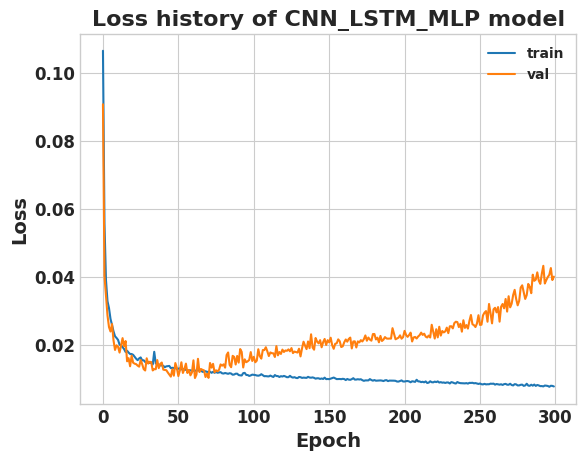

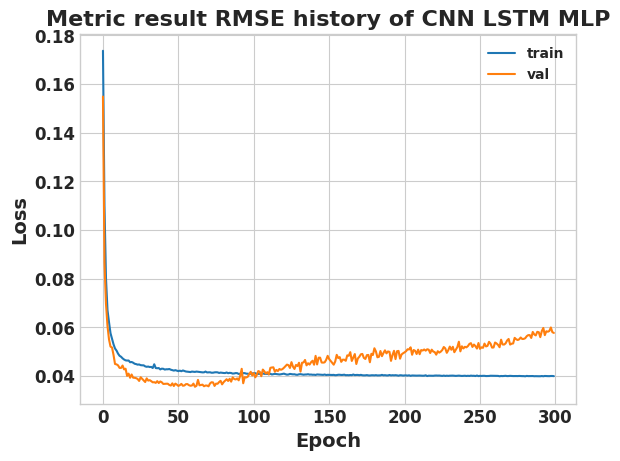

In [65]:
# Plot the history of loss and r2 of CNN LSTM MLP
plt.plot(history_cnn_lstm_mlp.history['loss'] , label='train')
plt.plot(history_cnn_lstm_mlp.history['val_loss'], label='val')
plt.title('Loss history of CNN_LSTM_MLP model' , weight='bold' , fontsize=16)
plt.xlabel('Epoch' , weight='bold' , fontsize=14)
plt.ylabel('Loss' , weight='bold' , fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()


plt.plot(history_cnn_lstm_mlp.history['root_mean_squared_error'] , label='train')
plt.plot(history_cnn_lstm_mlp.history['val_root_mean_squared_error'], label='val')
plt.title('Metric result RMSE history of CNN LSTM MLP' , weight='bold' , fontsize=16)
plt.xlabel('Epoch' , weight='bold' , fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()

# **CNN loss and Metric Plot**

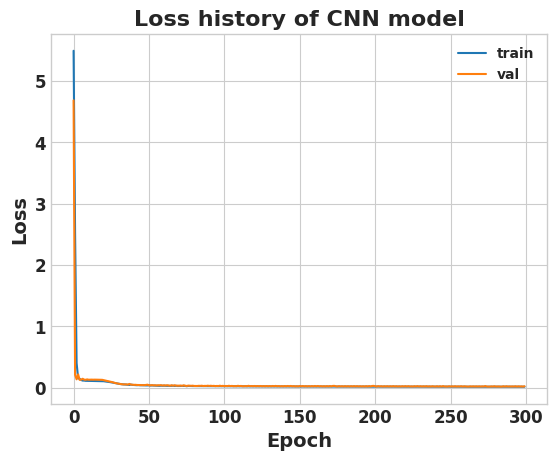

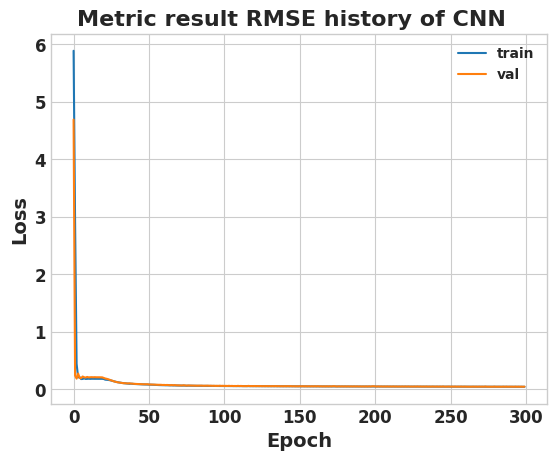

In [66]:
# Plot the history of loss and r2 of CNN LSTM MLP
plt.plot(loss_history_cnn , label='train')
plt.plot(historyCNN.history['val_loss'], label='val')
plt.title('Loss history of CNN model' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()


plt.plot(r2_history_cnn , label='train')
plt.plot(historyCNN.history['val_root_mean_squared_error'], label='val')
plt.title('Metric result RMSE history of CNN  ' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()

# **MLP loss and Metric Plot**

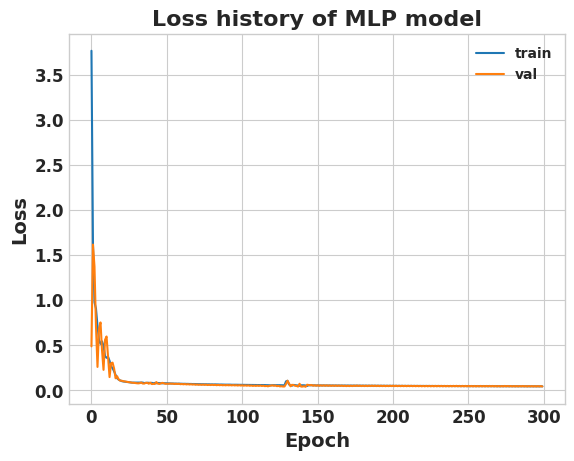

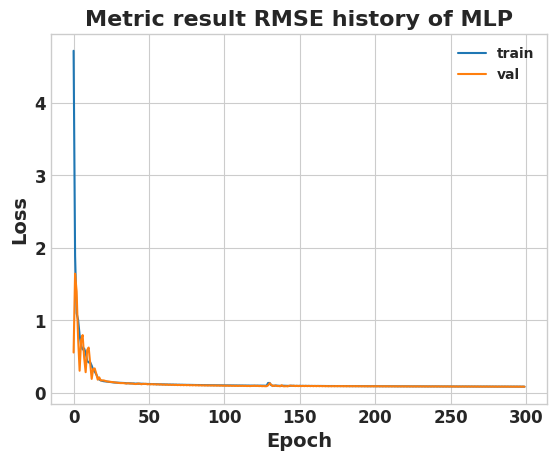

In [67]:
# Plot the history of loss and r2 of MLP
plt.plot(loss_history_mlp , label='train')
plt.plot(historyMLP.history['val_loss'], label='val')
plt.title('Loss history of MLP model' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()


plt.plot(r2_history_mlp , label='train')
plt.plot(historyMLP.history['val_root_mean_squared_error'], label='val')
plt.title('Metric result RMSE history of MLP' , weight='bold' ,  fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()

# **LSTM loss and Metric Plot**

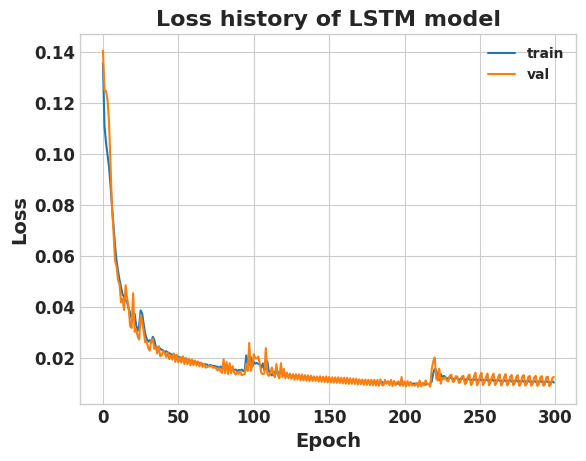

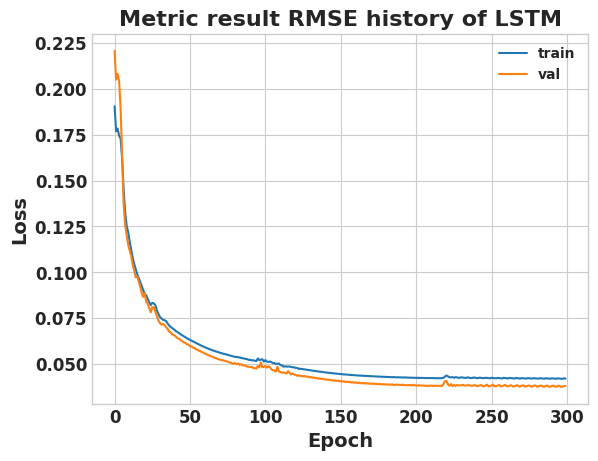

In [68]:
# Plot the history of loss and r2 of LSTM
plt.plot(loss_history_lstm , label='train')
plt.plot(historyLSTM.history['val_loss'], label='val')
plt.title('Loss history of LSTM model' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()


plt.plot(r2_history_lstm , label='train')
plt.plot(historyLSTM.history['val_root_mean_squared_error'], label='val')
plt.title('Metric result RMSE history of LSTM' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()

# **CNN-LSTM loss and Metric Plot**

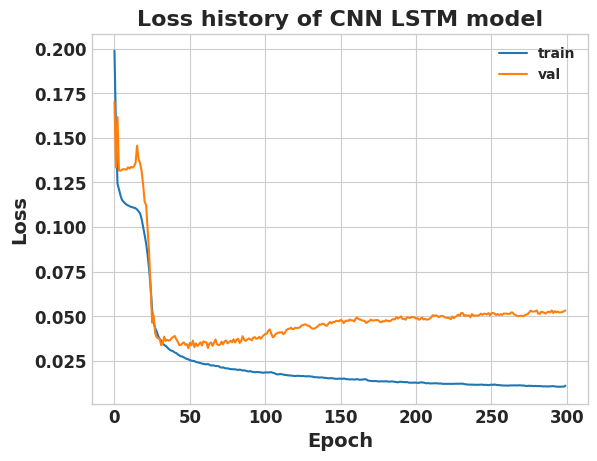

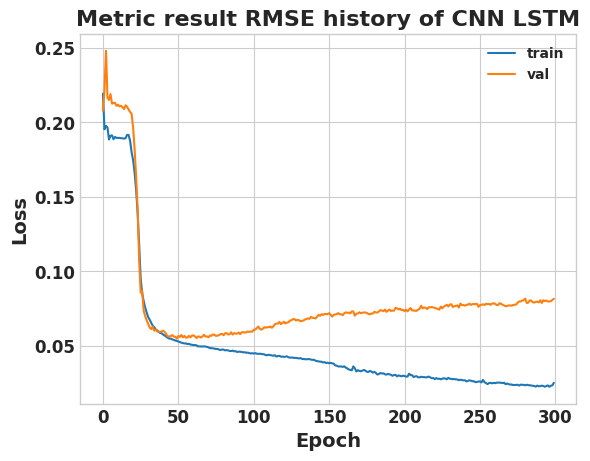

In [69]:
# Plot the history of loss and r2 of LSTM
plt.plot(loss_history_cnn_lstm , label='train')
plt.plot(history_cnn_lstm.history['val_loss'], label='val')
plt.title('Loss history of CNN LSTM model' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()


plt.plot(r2_history_cnn_lstm , label='train')
plt.plot(history_cnn_lstm.history['val_root_mean_squared_error'], label='val')
plt.title('Metric result RMSE history of CNN LSTM' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()

# CNN Attention LSTM loss and Metric Plot

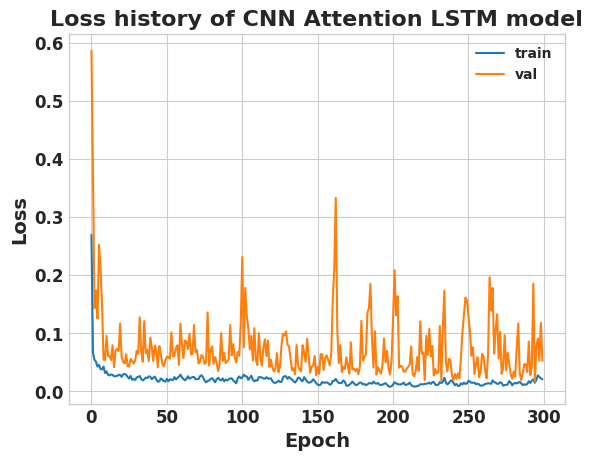

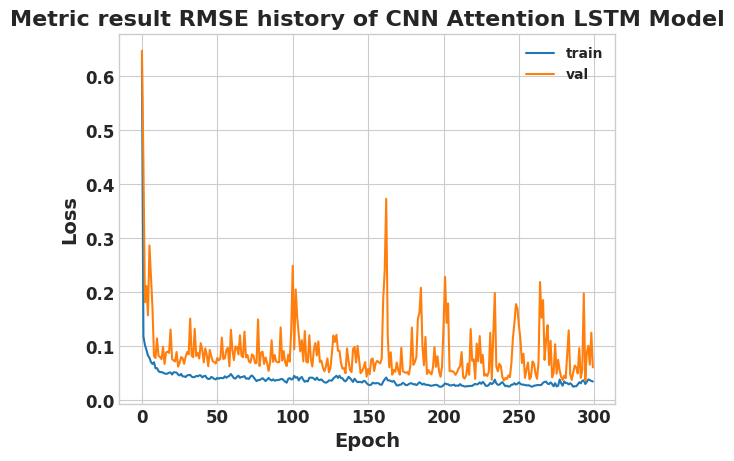

In [70]:
# Plot the history of loss and r2 of Proposed
plt.plot(loss_history_cnn_a_lstm , label='train')
plt.plot(history_cnn_a_lstm.history['val_loss'], label='val')
plt.title('Loss history of CNN Attention LSTM model' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()


plt.plot(r2_history_cnn_a_lstm , label='train')
plt.plot(history_cnn_a_lstm.history['val_root_mean_squared_error'], label='val')
plt.title('Metric result RMSE history of CNN Attention LSTM Model' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()

# Attention Loss and Metrics Plot

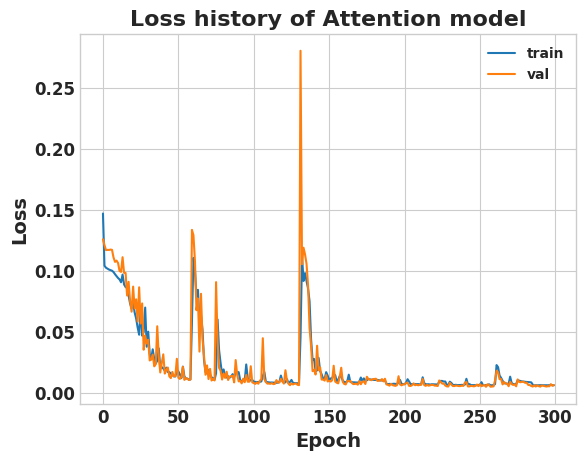

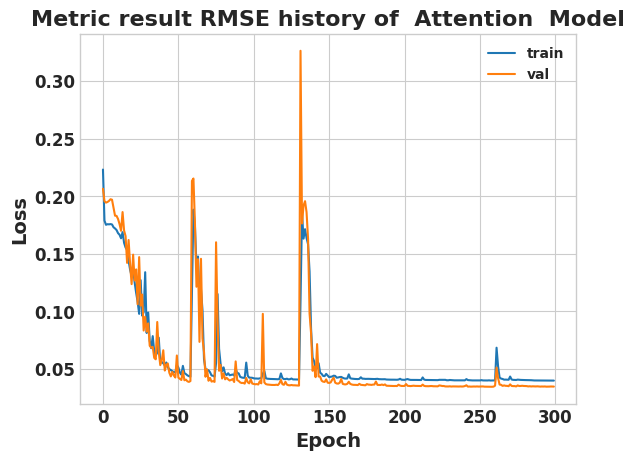

In [71]:
# Plot the history of loss and r2 of Proposed
plt.plot(loss_history_attention , label='train')
plt.plot(history_attention.history['val_loss'], label='val')
plt.title('Loss history of Attention model' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()


plt.plot(r2_history_attention , label='train')
plt.plot(history_attention.history['val_root_mean_squared_error'], label='val')
plt.title('Metric result RMSE history of  Attention  Model' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()

# TCN Loss and Metrics Plot

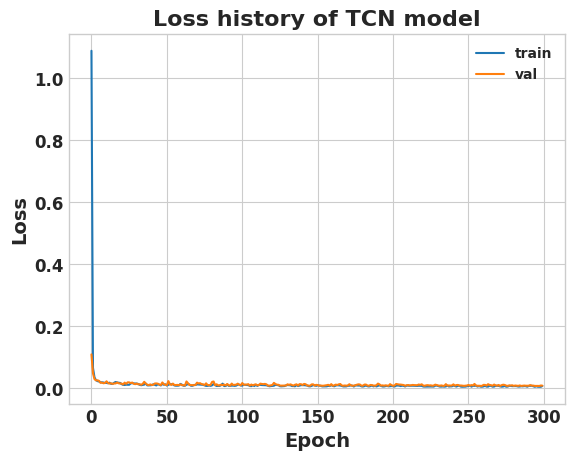

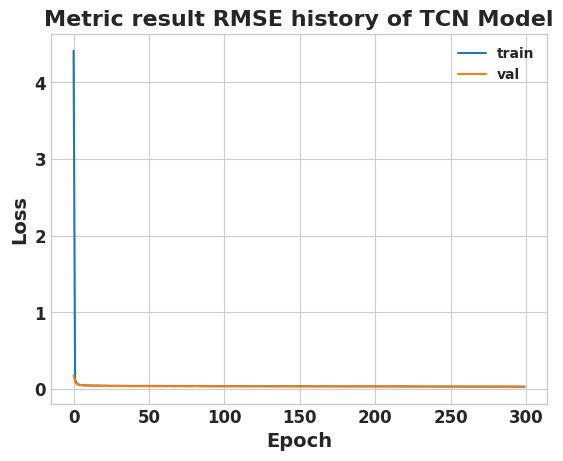

In [72]:
# Plot the history of loss and r2 of Proposed
plt.plot(loss_history_tcn , label='train')
plt.plot(history_tcn.history['val_loss'], label='val')
plt.title('Loss history of TCN model' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()


plt.plot(r2_history_tcn , label='train')
plt.plot(history_tcn.history['val_root_mean_squared_error'], label='val')
plt.title('Metric result RMSE history of TCN Model' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()

# Bi-LSTM Loss and Metrics Plot

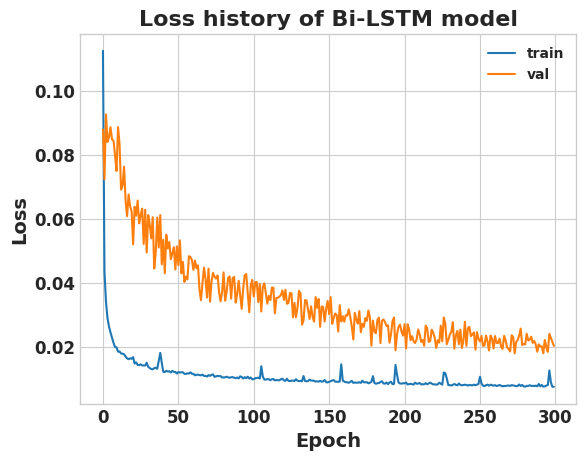

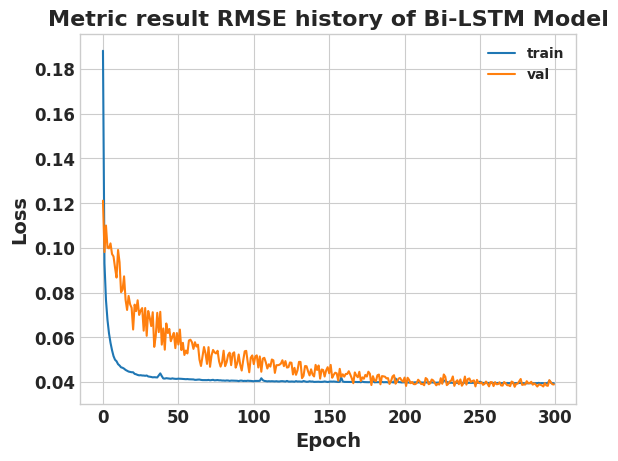

In [73]:
# Plot the history of loss and r2 of Proposed
plt.plot(loss_history_esn , label='train')
plt.plot(history_esn.history['val_loss'], label='val')
plt.title('Loss history of Bi-LSTM model' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()


plt.plot(r2_history_esn , label='train')
plt.plot(history_esn.history['val_root_mean_squared_error'], label='val')
plt.title('Metric result RMSE history of Bi-LSTM Model' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()

# Proposed loss and Metric Plot

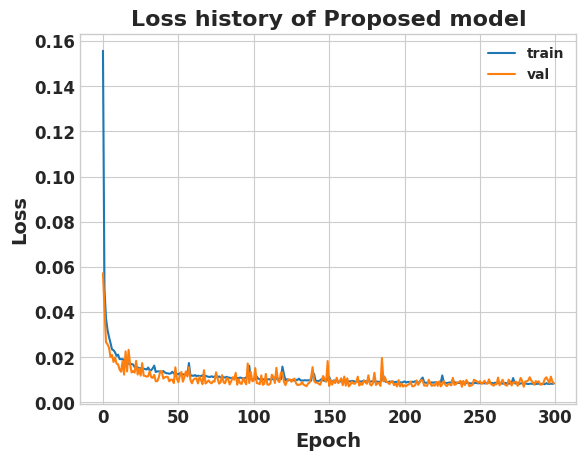

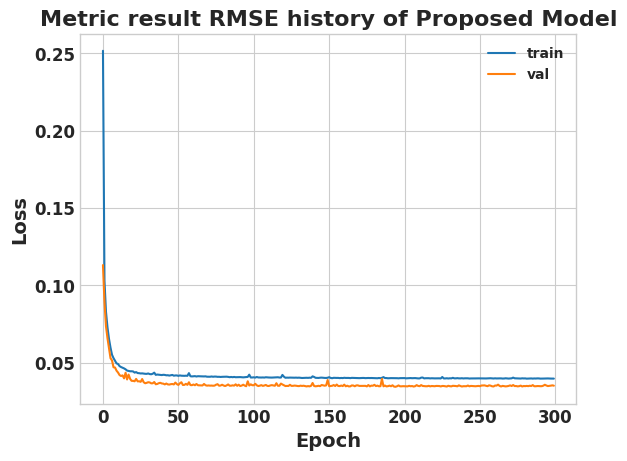

In [74]:
# Plot the history of loss and r2 of Proposed
plt.plot(loss_history_proposed , label='train')
plt.plot(history_cnn_lstm_knn.history['val_loss'], label='val')
plt.title('Loss history of Proposed model' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()


plt.plot(r2_history_proposed , label='train')
plt.plot(history_cnn_lstm_knn.history['val_root_mean_squared_error'], label='val')
plt.title('Metric result RMSE history of Proposed Model' , weight='bold', fontsize=16)
plt.xlabel('Epoch' , weight='bold', fontsize=14)
plt.ylabel('Loss' , weight='bold', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)  # Adjust x-ticks size
plt.yticks(fontsize=12)  # Adjust y-ticks size
plt.show()

In [75]:
# CNN LSTM MLP
t1 = t.time()
cnn_lstm_mlp_predictions = cnn_lstm_mlp.predict(x_test)
infer_cnn_lstm_mlp = t.time() - t1

# CNN prediction
t1 = t.time()
predictionCNN = modelCNN.predict(x_test)
inferCNN = t.time() - t1

# MLP prediction
t1 = t.time()
predictionMLP = modelMLP.predict(x_test)
inferMLP = t.time() - t1

# LSTM prediction
t1 = t.time()
predictionLSTM = modelLSTM.predict(x_test)
inferLSTM = t.time() - t1

# CNN LSTM prediction
t1 = t.time()
prediction_cnn_lstm = model_cnn_lstm.predict(x_test)
infer_cnn_lstm = t.time() - t1

# CNN Attention LSTM prediction
t1 = t.time()
prediction_cnn_a_lstm = model_cnn_a_lstm.predict(x_test)
infer_cnn_a_lstm = t.time() - t1

# Attention prediction
t1 = t.time()
prediction_attention = model_attention.predict(x_test)
infer_attention = t.time() - t1

# TCN prediction
t1 = t.time()
prediction_tcn = model_tcn.predict(x_test)
infer_tcn = t.time() - t1

# ESN prediction
t1 = t.time()
prediction_esn = model_esn.predict(x_test)
infer_esn = t.time() - t1


# Proposed
t1 = t.time()
proposed_predictions = proposed.predict(flatten_output_test)
infer_proposed = t.time() - t1

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [76]:
#Calculating Mean Absolute Error
#Import Libraries
from sklearn.metrics import mean_absolute_error 

mae_CNNLSTMMLP = mean_absolute_error(y_test, cnn_lstm_mlp_predictions) # it can be raw_values
print('Mean Absolute Error Value CNN-LSTM-MLP : ',  round(mae_CNNLSTMMLP, 6))

MAE_CNN = mean_absolute_error(y_test, predictionCNN.reshape(predictionCNN.shape[0])  )
print("Mean Absolute Error (CNN):", round(MAE_CNN, 6))

MAE_MLP = mean_absolute_error(y_test, predictionMLP.reshape(predictionMLP.shape[0])  )
print("Mean Absolute Error (MLP):", round(MAE_MLP, 6))

MAE_LSTM = mean_absolute_error(y_test, predictionLSTM.reshape(predictionLSTM.shape[0]))
print("Mean Absolute Error (LSTM):", round(MAE_LSTM, 6))

MAE_cnn_lstm = mean_absolute_error(y_test, prediction_cnn_lstm.reshape(prediction_cnn_lstm.shape[0]))
print("Mean Absolute Error (CNN LSTM):", round(MAE_cnn_lstm, 6))

MAE_cnn_a_lstm = mean_absolute_error(y_test, prediction_cnn_a_lstm.reshape(prediction_cnn_a_lstm.shape[0]))
print("Mean Absolute Error (CNN Attention LSTM):", round(MAE_cnn_a_lstm, 6))

MAE_attention = mean_absolute_error(y_test, prediction_attention.reshape(prediction_attention.shape[0]))
print("Mean Absolute Error (Attention):", round(MAE_attention, 6))

MAE_tcn = mean_absolute_error(y_test, prediction_tcn.reshape(prediction_tcn.shape[0]))
print("Mean Absolute Error (TCN):", round(MAE_tcn, 6))

MAE_esn = mean_absolute_error(y_test, prediction_esn.reshape(prediction_esn.shape[0]))
print("Mean Absolute Error (Bi-LSTM):", round(MAE_esn, 6))

mae_proposed = mean_absolute_error(y_test, proposed_predictions.reshape(proposed_predictions.shape[0])  )
print("Mean Absolute Error Proposed Model:", round(mae_proposed, 6))

Mean Absolute Error Value CNN-LSTM-MLP :  0.089053
Mean Absolute Error (CNN): 0.026559
Mean Absolute Error (MLP): 0.06461
Mean Absolute Error (LSTM): 0.01729
Mean Absolute Error (CNN LSTM): 0.122777
Mean Absolute Error (CNN Attention LSTM): 0.056177
Mean Absolute Error (Attention): 0.009168
Mean Absolute Error (TCN): 0.014521
Mean Absolute Error (Bi-LSTM): 0.024693
Mean Absolute Error Proposed Model: 0.011806


In [77]:
#Calculating Mean Absolute Error
#Import Libraries
from sklearn.metrics import mean_absolute_error 

mse_CNNLSTMMLP = mean_squared_error(y_test, cnn_lstm_mlp_predictions) # it can be raw_values
print('Mean Squared Error Value CNN-LSTM-MLP : ',  round(mse_CNNLSTMMLP, 6))

MSE_CNN = mean_squared_error(y_test, predictionCNN.reshape(predictionCNN.shape[0])  )
print("Mean Squared Error (CNN):", round(MSE_CNN, 6))

MSE_MLP = mean_squared_error(y_test, predictionMLP.reshape(predictionMLP.shape[0])  )
print("Mean Squared Error (MLP):", round(MSE_MLP, 6))

MSE_LSTM = mean_squared_error(y_test, predictionLSTM.reshape(predictionLSTM.shape[0]))
print("Mean Squared Error (LSTM):", round(MSE_LSTM, 6))

MSE_cnn_lstm = mean_squared_error(y_test, prediction_cnn_lstm.reshape(prediction_cnn_lstm.shape[0]))
print("Mean Squared Error (CNN LSTM):", round(MAE_cnn_lstm, 6))

MSE_cnn_a_lstm = mean_absolute_error(y_test, prediction_cnn_a_lstm.reshape(prediction_cnn_a_lstm.shape[0]))
print("Mean Squared Error (CNN Attention LSTM):", round(MSE_cnn_a_lstm, 6))

MSE_attention = mean_absolute_error(y_test, prediction_attention.reshape(prediction_attention.shape[0]))
print("Mean Squared Error (Attention):", round(MSE_attention, 6))

MSE_tcn = mean_absolute_error(y_test, prediction_tcn.reshape(prediction_tcn.shape[0]))
print("Mean Squared Error (TCN):", round(MSE_tcn, 6))

MSE_esn = mean_absolute_error(y_test, prediction_esn.reshape(prediction_esn.shape[0]))
print("Mean Squared Error (Bi-LSTM):", round(MSE_esn, 6))

mse_proposed = mean_squared_error(y_test, proposed_predictions.reshape(proposed_predictions.shape[0])  )
print("Mean Squared Error Proposed Model:", round(mse_proposed, 6))


Mean Squared Error Value CNN-LSTM-MLP :  0.008893
Mean Squared Error (CNN): 0.003178
Mean Squared Error (MLP): 0.017022
Mean Squared Error (LSTM): 0.002278
Mean Squared Error (CNN LSTM): 0.122777
Mean Squared Error (CNN Attention LSTM): 0.056177
Mean Squared Error (Attention): 0.009168
Mean Squared Error (TCN): 0.014521
Mean Squared Error (Bi-LSTM): 0.024693
Mean Squared Error Proposed Model: 0.000968


In [78]:
print("Root Mean Squared Error (CNN-LSTM-MLP):", round(math.sqrt(mse_CNNLSTMMLP), 6))

print("Root Mean Squared Error (CNN):", round(math.sqrt(MSE_CNN), 6))

print("Root Mean Squared Error (MLP):", round(math.sqrt(MSE_MLP), 6))

print("Root Mean Squared Error (LSTM):", round(math.sqrt(MSE_LSTM), 6))

print("Root Mean Squared Error (CNN LSTM):", round(math.sqrt(MSE_cnn_lstm), 6))

print("Root Mean Squared Error (CNN Attention LSTM):", round(math.sqrt(MSE_cnn_a_lstm), 6))

print("Root Mean Squared Error (Attention):", round(math.sqrt(MSE_attention), 6))

print("Root Mean Squared Error (TCN):", round(math.sqrt(MSE_tcn), 6))

print("Root Mean Squared Error (Bi-LSTM):", round(math.sqrt(MSE_esn), 6))

print("Root Mean Squared Error Proposed Model:", round(math.sqrt(mse_proposed), 6))


Root Mean Squared Error (CNN-LSTM-MLP): 0.094305
Root Mean Squared Error (CNN): 0.056373
Root Mean Squared Error (MLP): 0.130468
Root Mean Squared Error (LSTM): 0.047732
Root Mean Squared Error (CNN LSTM): 0.138508
Root Mean Squared Error (CNN Attention LSTM): 0.237017
Root Mean Squared Error (Attention): 0.095748
Root Mean Squared Error (TCN): 0.120501
Root Mean Squared Error (Bi-LSTM): 0.157141
Root Mean Squared Error Proposed Model: 0.031107


In [79]:
R2_acc_cnn_lstm_mlp = r2_score(y_test, cnn_lstm_mlp_predictions)
r2_cnn = r2_score(y_test, predictionCNN.reshape(predictionCNN.shape[0]))
r2_mlp = r2_score(y_test, predictionMLP.reshape(predictionMLP.shape[0]))
r2_lstm = r2_score(y_test, predictionLSTM.reshape(predictionLSTM.shape[0]))
r2_cnn_lstm = r2_score(y_test, prediction_cnn_lstm.reshape(prediction_cnn_lstm.shape[0]))
r2_cnn_a_lstm = r2_score(y_test, prediction_cnn_a_lstm.reshape(prediction_cnn_a_lstm.shape[0]))
r2_attention = r2_score(y_test, prediction_attention.reshape(prediction_attention.shape[0]))
r2_tcn = r2_score(y_test, prediction_tcn.reshape(prediction_tcn.shape[0]))
r2_esn = r2_score(y_test, prediction_esn.reshape(prediction_esn.shape[0]))
r2acc_proposed = r2_score(y_test, proposed_predictions.reshape(proposed_predictions.shape[0]))


In [80]:
print("R2 accuracy of CNN-LSTM-MLP model is :",round(R2_acc_cnn_lstm_mlp, 6)   )

print("R2 accuracy of CNN model is :",round(r2_cnn, 6)  )

print("R2 accuracy of MLP model is :",round(r2_mlp , 6)   )

print("R2 accuracy of LSTM model is :",round(r2_lstm, 6))

print("R2 accuracy of CNN LSTM model is :",round(r2_cnn_lstm, 6))

print("R2 accuracy of CNN Attention LSTM model is :",round(r2_cnn_a_lstm, 6))

print("R2 accuracy of Attention model is :",round(r2_attention, 6))

print("R2 accuracy of TCN model is :",round(r2_tcn, 6))

print("R2 accuracy of Bi-LSTM model is :",round(r2_esn, 6))


print("R2 accuracy of Proposed model is :",round(r2acc_proposed, 6)   )

R2 accuracy of CNN-LSTM-MLP model is : 0.885044
R2 accuracy of CNN model is : 0.958923
R2 accuracy of MLP model is : 0.779978
R2 accuracy of LSTM model is : 0.970551
R2 accuracy of CNN LSTM model is : 0.752022
R2 accuracy of CNN Attention LSTM model is : 0.935762
R2 accuracy of Attention model is : 0.981776
R2 accuracy of TCN model is : 0.9822
R2 accuracy of Bi-LSTM model is : 0.978699
R2 accuracy of Proposed model is : 0.987492


<Figure size 1400x2000 with 0 Axes>

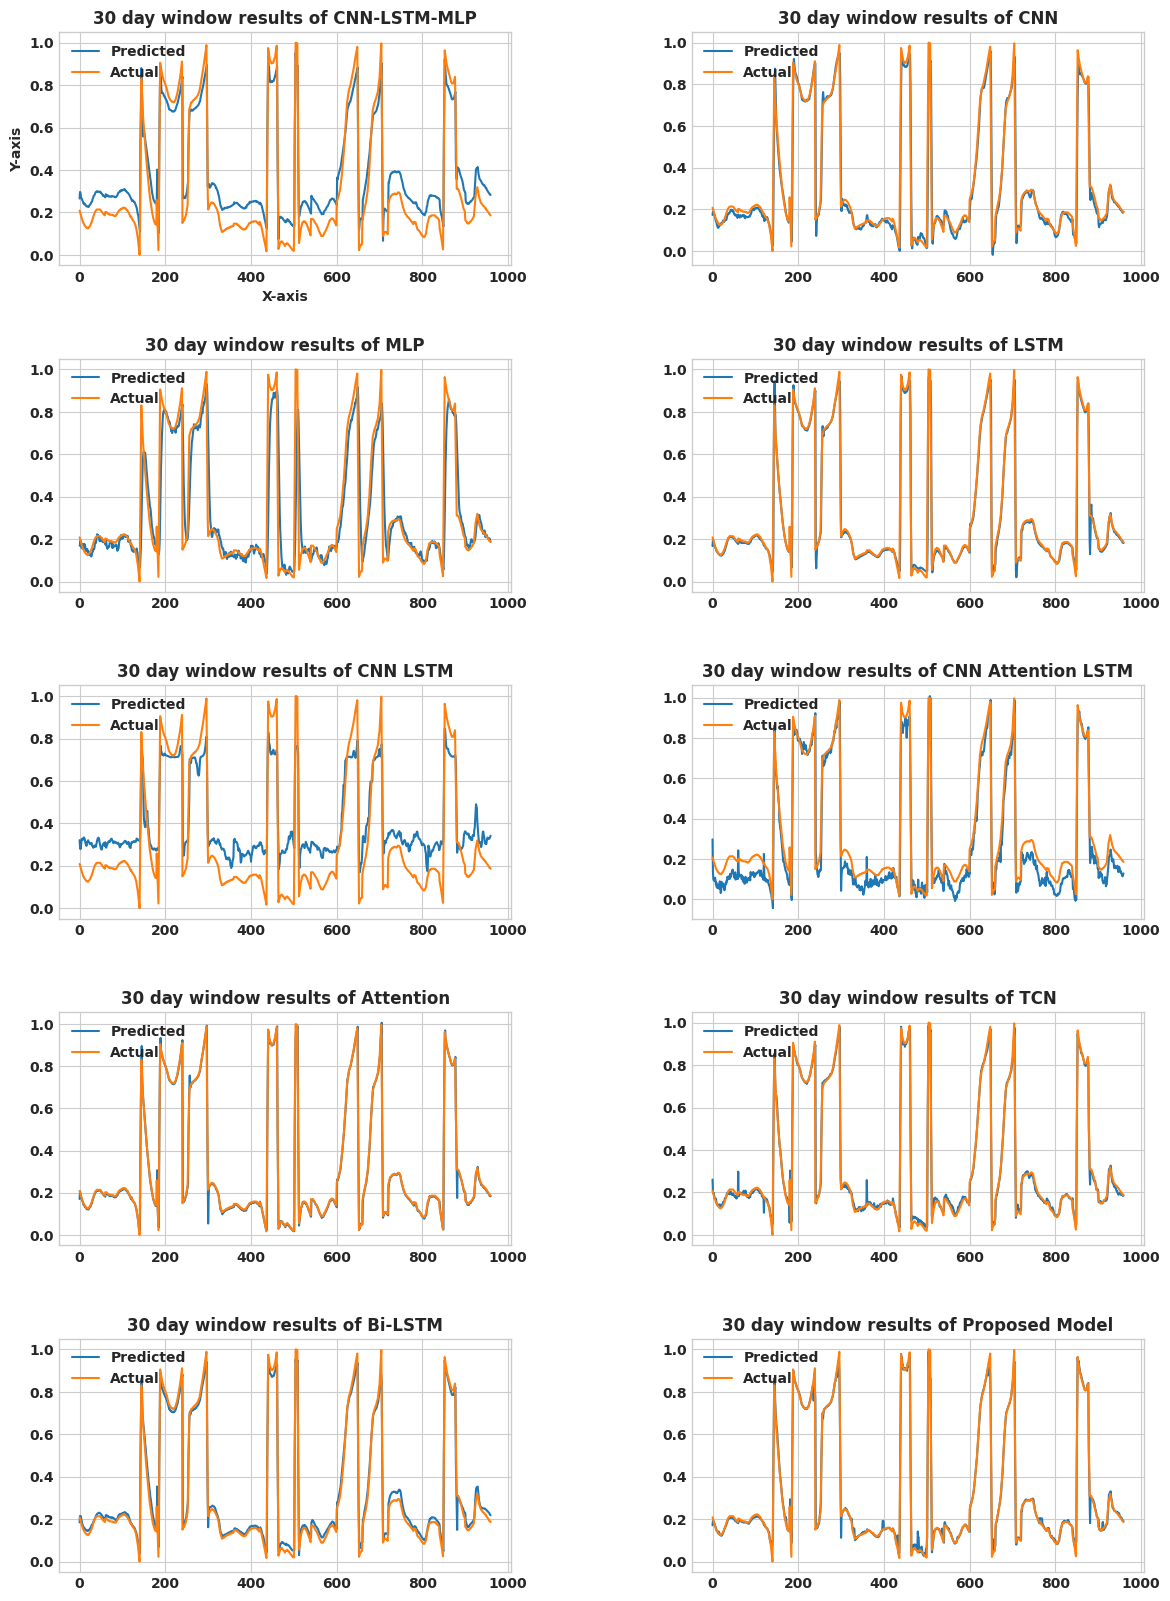

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Make the figure size bigger
plt.figure(figsize=(14, 20))  # Adjusted figure size for better spacing

# Set global font weight
rcParams['font.weight'] = 'bold'

# Define the testing days (example)
testing_days = 30

# Create subplots and adjust the layout for better spacing
fig, axs = plt.subplots(5, 2, figsize=(14, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust margins between plots

# Cnn-LStm-MLP's prediction plot
axs[0, 0].plot(cnn_lstm_mlp_predictions)
axs[0, 0].plot(y_test)
axs[0, 0].set_title(f'{testing_days} day window results of CNN-LSTM-MLP', weight='bold')
axs[0, 0].set_xlabel('X-axis', weight='bold')
axs[0, 0].set_ylabel('Y-axis', weight='bold')
axs[0, 0].legend(['Predicted', 'Actual'], loc="upper left")

# CNN's prediction plot
axs[0, 1].plot(predictionCNN)
axs[0, 1].plot(y_test)
axs[0, 1].set_title(f'{testing_days} day window results of CNN', weight='bold')
axs[0, 1].legend(['Predicted', 'Actual'], loc="upper left")

# MLP's prediction plot
axs[1, 0].plot(predictionMLP)
axs[1, 0].plot(y_test)
axs[1, 0].set_title(f'{testing_days} day window results of MLP', weight='bold')
axs[1, 0].legend(['Predicted', 'Actual'], loc="upper left")

# LSTM's prediction plot
axs[1, 1].plot(predictionLSTM)
axs[1, 1].plot(y_test)
axs[1, 1].set_title(f'{testing_days} day window results of LSTM', weight='bold')
axs[1, 1].legend(['Predicted', 'Actual'], loc="upper left")

# CNN LSTM's prediction plot
axs[2, 0].plot(prediction_cnn_lstm)
axs[2, 0].plot(y_test)
axs[2, 0].set_title(f'{testing_days} day window results of CNN LSTM', weight='bold')
axs[2, 0].legend(['Predicted', 'Actual'], loc="upper left")

# CNN Attention LSTM's prediction plot
axs[2, 1].plot(prediction_cnn_a_lstm)
axs[2, 1].plot(y_test)
axs[2, 1].set_title(f'{testing_days} day window results of CNN Attention LSTM', weight='bold')
axs[2, 1].legend(['Predicted', 'Actual'], loc="upper left")

# Attention prediction plot
axs[3, 0].plot(prediction_attention)
axs[3, 0].plot(y_test)
axs[3, 0].set_title(f'{testing_days} day window results of Attention', weight='bold')
axs[3, 0].legend(['Predicted', 'Actual'], loc="upper left")

# TCN prediction plot
axs[3, 1].plot(prediction_tcn)
axs[3, 1].plot(y_test)
axs[3, 1].set_title(f'{testing_days} day window results of TCN', weight='bold')
axs[3, 1].legend(['Predicted', 'Actual'], loc="upper left")

# ESN prediction plot
axs[4, 0].plot(prediction_esn)
axs[4, 0].plot(y_test)
axs[4, 0].set_title(f'{testing_days} day window results of Bi-LSTM', weight='bold')
axs[4, 0].legend(['Predicted', 'Actual'], loc="upper left")

# Proposed prediction plot
axs[4, 1].plot(proposed_predictions)
axs[4, 1].plot(y_test)
axs[4, 1].set_title(f'{testing_days} day window results of Proposed Model', weight='bold')
axs[4, 1].legend(['Predicted', 'Actual'], loc="upper left")

# Save the plot
plt.savefig('predicted_graphs.png')

# Show the plot
plt.show()


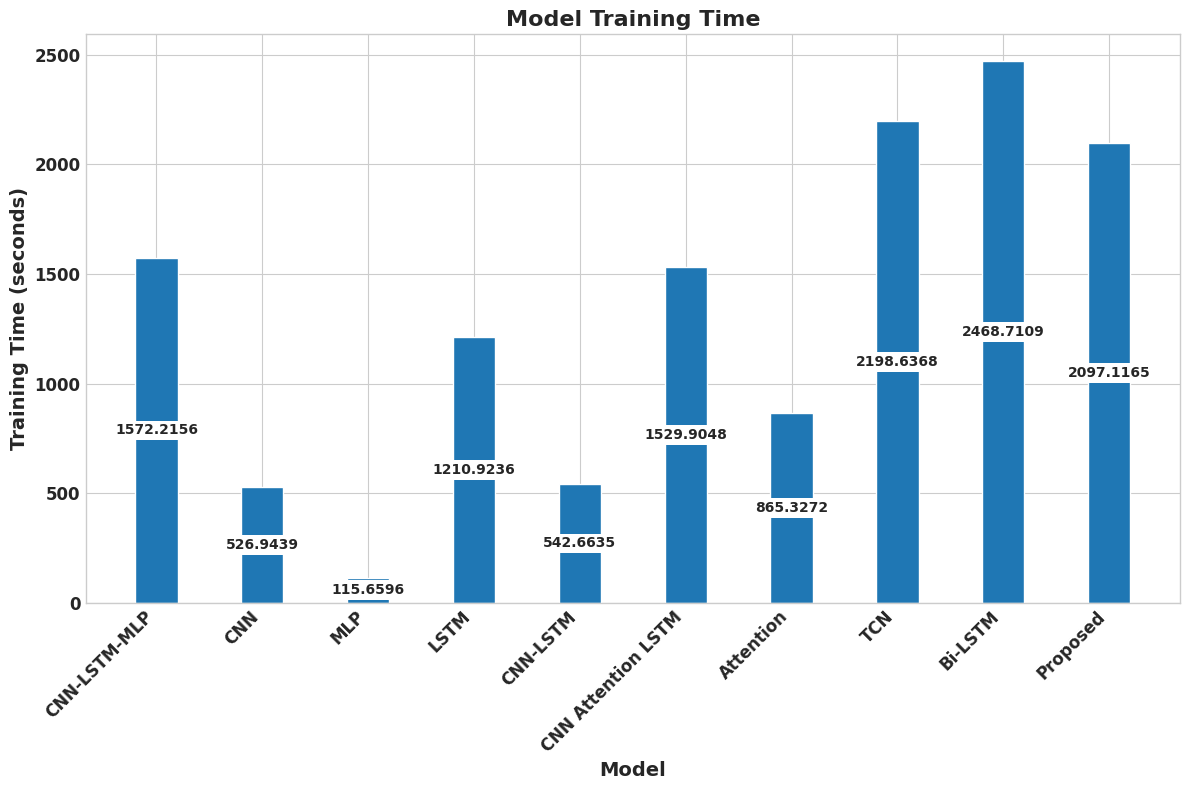

In [82]:
import numpy as np
import matplotlib.pyplot as plt

models = ['CNN-LSTM-MLP', 'CNN', 'MLP', 'LSTM', 'CNN-LSTM', 'CNN Attention LSTM', 'Attention', 'TCN', 'Bi-LSTM', 'Proposed']
timeTrain = [time_cnn_lstm_mlp, timeCNN, timeMLP, timeLSTM, time_cnn_lstm, time_cnn_a_lstm, time_attention, time_tcn, time_esn, time_cnn_lstm_knn]

bar_width = 0.4  # Adjust the width as per your preference

plt.figure(figsize=(12, 8))  # Set the figure size

plt.bar(np.arange(len(models)), timeTrain, width=bar_width)
plt.xlabel('Model', weight='bold', fontsize=14)  # Control size of x label
plt.ylabel('Training Time (seconds)', weight='bold', fontsize=14)  # Control size of y label
plt.title('Model Training Time', weight='bold', fontsize=16)  # Control size of title

# Set the x-axis tick labels to the model names with rotation and font size
plt.xticks(np.arange(len(models)), models, fontsize=12, rotation=45, ha='right')  
plt.yticks(fontsize=12)  # Control size of y-axis ticks

# Display the numerical values on the chart
for i in range(len(models)):
    plt.text(i, timeTrain[i]/2, "{:.4f}".format(timeTrain[i]), ha='center', va='center', rotation=0,
             bbox=dict(facecolor='white', edgecolor='none', pad=2))  # Adjust the pad value for margin

plt.tight_layout()  # Adjust layout to make room for x-labels
plt.savefig('/kaggle/working/trainingImg.png')
plt.show()


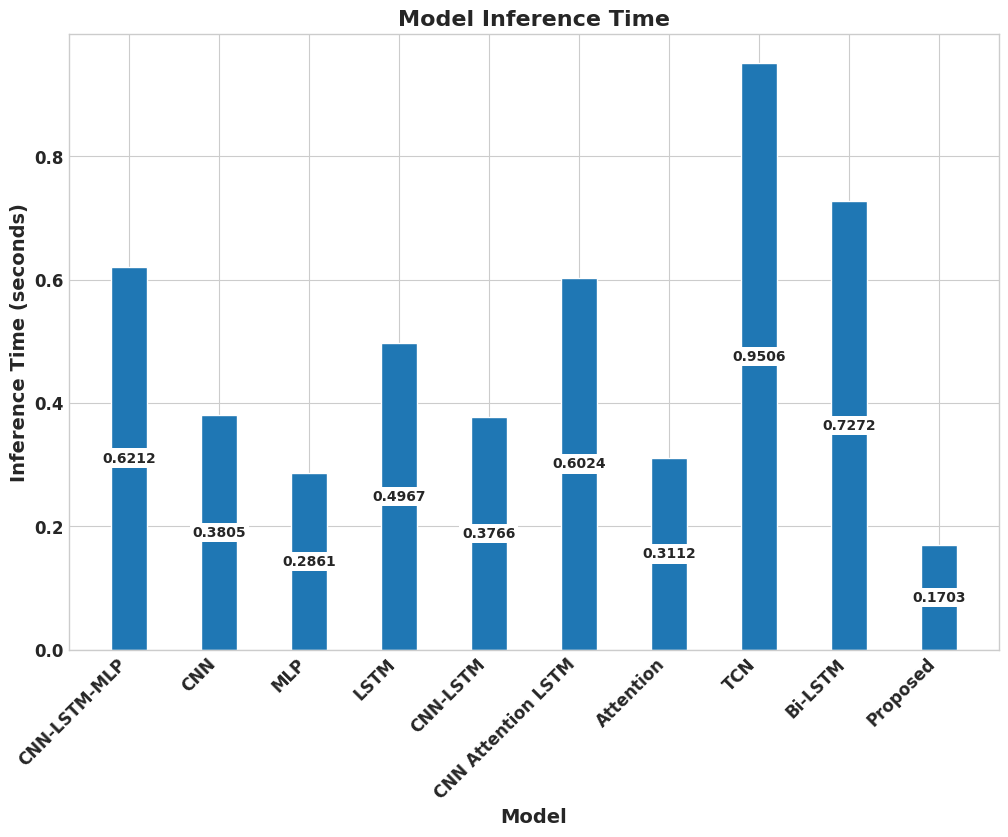

In [83]:
timeInfer = [infer_cnn_lstm_mlp , inferCNN, inferMLP, inferLSTM ,infer_cnn_lstm,infer_cnn_a_lstm, infer_attention,infer_tcn, infer_esn, infer_proposed]

bar_width = 0.4  # Adjust the width as per your preference

plt.figure(figsize=(12, 8))  # Set the figure size

plt.bar(np.arange(len(models)), timeInfer, width=bar_width)
plt.xlabel('Model' , weight='bold', fontsize=14)
plt.ylabel('Inference Time (seconds)' , weight='bold', fontsize=14)
plt.title('Model Inference Time' , weight='bold', fontsize=16)

# Set the x-axis tick labels to the model names with rotation and font size
plt.xticks(np.arange(len(models)), models, fontsize=12, rotation=45, ha='right')  
plt.yticks(fontsize=12)  # Control size of y-axis ticks

# Display the numerical values on the chart
for i in range(len(models)):
    plt.text(i, timeInfer[i]/2, "{:.4f}".format(timeInfer[i]), ha='center', va='center', rotation=0,
             bbox=dict(facecolor='white', edgecolor='none', pad=2))  # Adjust the pad value for margin

    
    
plt.savefig('/kaggle/working/InferingImg.png')
plt.show()

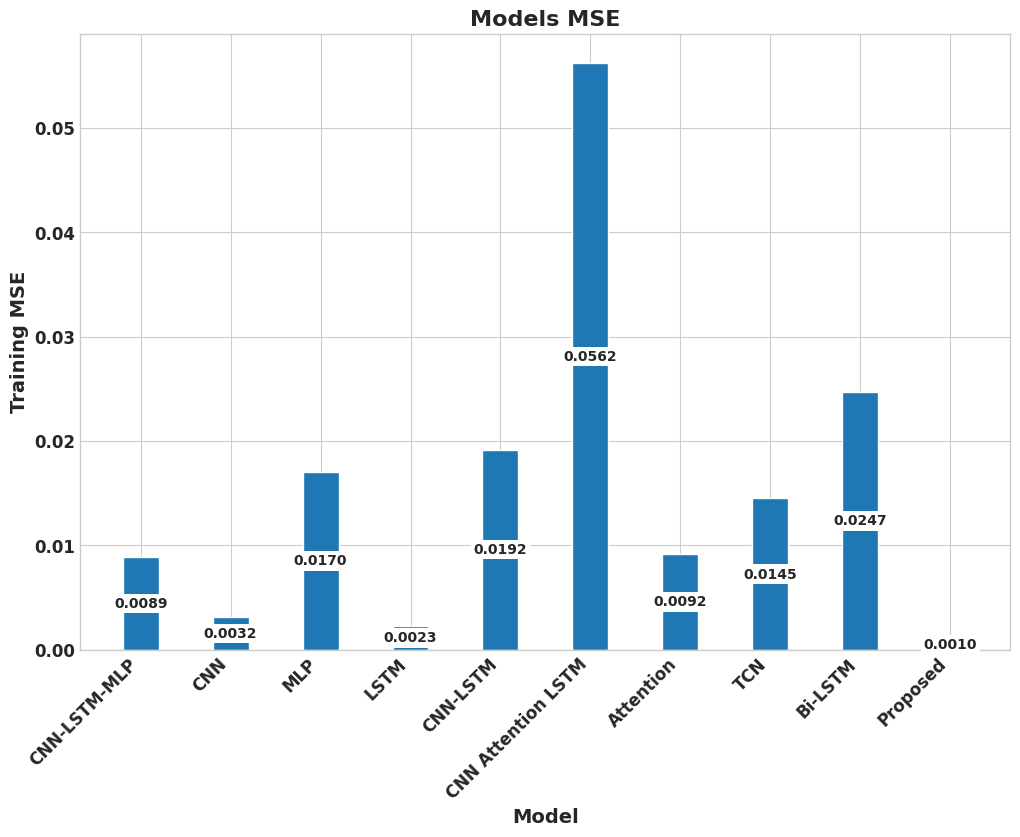

In [84]:
MSE = [mse_CNNLSTMMLP,MSE_CNN, MSE_MLP, MSE_LSTM, MSE_cnn_lstm ,MSE_cnn_a_lstm , MSE_attention , MSE_tcn , MSE_esn , mse_proposed]
    
bar_width = 0.4  # Adjust the width as per your preference
plt.figure(figsize=(12, 8))  # Set the figure size


plt.bar(np.arange(len(models)), MSE, width=bar_width)
plt.xlabel('Model' , weight='bold', fontsize=14)
plt.ylabel('Training MSE' , weight='bold', fontsize=14)
plt.title('Models MSE' , weight='bold', fontsize=16)

# Set the x-axis tick labels to the model names with rotation and font size
plt.xticks(np.arange(len(models)), models, fontsize=12, rotation=45, ha='right')  
plt.yticks(fontsize=12)  # Control size of y-axis ticks
# Display the numerical values on the chart
for i in range(len(models)):
    plt.text(i, MSE[i]/2, "{:.4f}".format(MSE[i]), ha='center', va='center', rotation=0,
             bbox=dict(facecolor='white', edgecolor='none', pad=2))  # Adjust the pad value for margin
    
plt.savefig('/kaggle/working/mse.png')
plt.show()

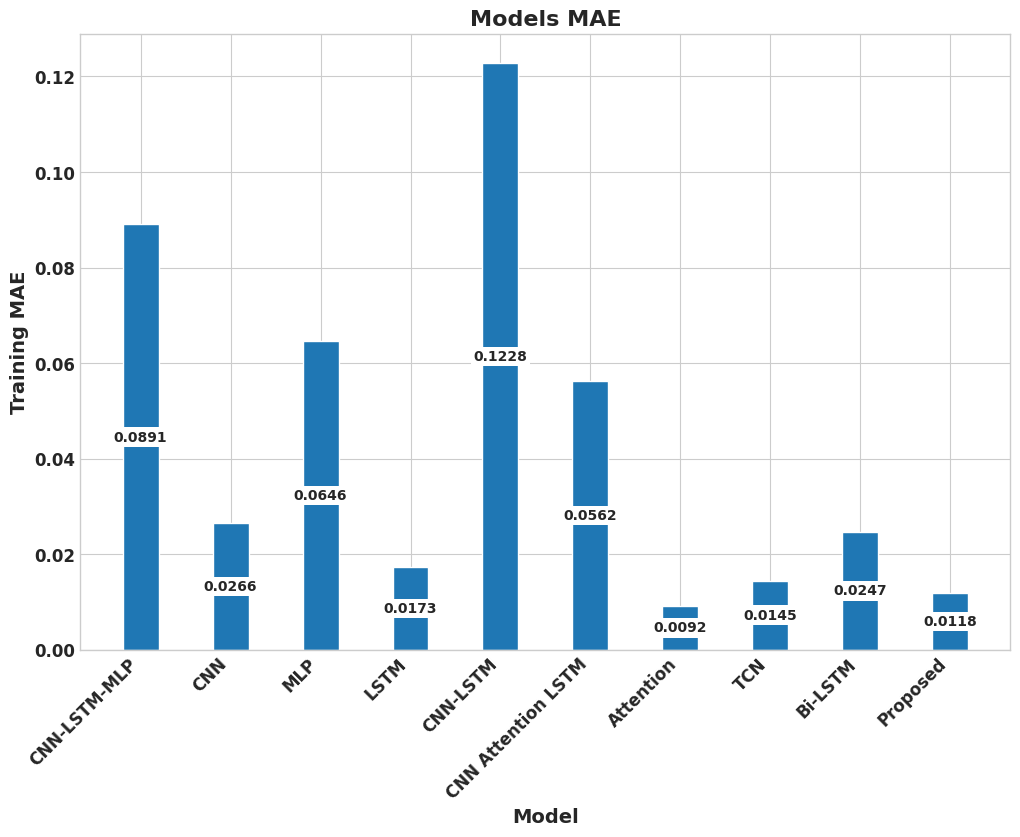

In [85]:
MAE = [mae_CNNLSTMMLP,MAE_CNN, MAE_MLP, MAE_LSTM, MAE_cnn_lstm ,MAE_cnn_a_lstm , MAE_attention , MAE_tcn , MAE_esn , mae_proposed]

bar_width = 0.4  # Adjust the width as per your preference

plt.figure(figsize=(12, 8))  # Set the figure size
plt.bar(np.arange(len(models)), MAE, width=bar_width)
plt.xlabel('Model' , weight='bold' , fontsize=14)
plt.ylabel('Training MAE' , weight='bold' , fontsize=14)
plt.title('Models MAE' , weight='bold' , fontsize=16)

# Set the x-axis tick labels to the model names with rotation and font size
plt.xticks(np.arange(len(models)), models, fontsize=12, rotation=45, ha='right')  
plt.yticks(fontsize=12)  # Control size of y-axis ticks

# Display the numerical values on the chart
for i in range(len(models)):
    plt.text(i, MAE[i]/2, "{:.4f}".format(MAE[i]), ha='center', va='center', rotation=0,
             bbox=dict(facecolor='white', edgecolor='none', pad=2))  # Adjust the pad value for margin

plt.savefig('/kaggle/working/mae.png')
plt.show()

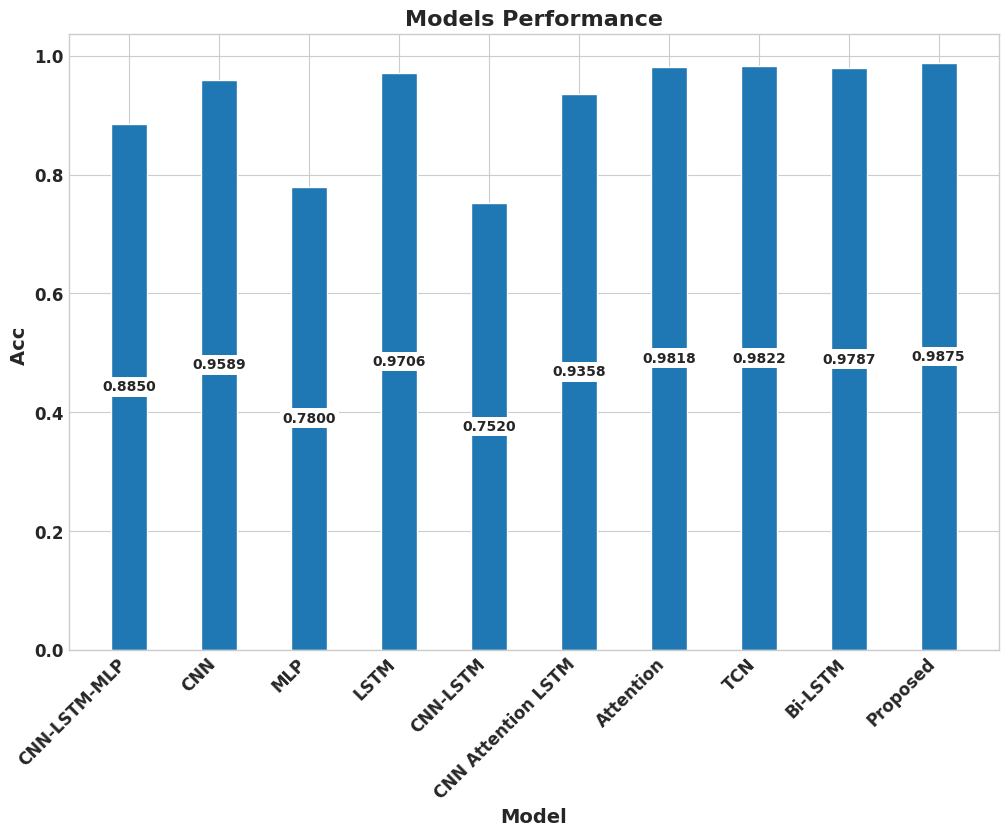

In [86]:
R2 = [R2_acc_cnn_lstm_mlp , r2_cnn, r2_mlp, r2_lstm ,r2_cnn_lstm,r2_cnn_a_lstm,r2_attention,r2_tcn,r2_esn, r2acc_proposed]


bar_width = 0.4  # Adjust the width as per your preference

plt.figure(figsize=(12, 8))  # Set the figure size
plt.bar(np.arange(len(models)), R2, width=bar_width)
plt.xlabel('Model' , weight='bold', fontsize=14)
plt.ylabel('Acc ' , weight='bold', fontsize=14)
plt.title('Models Performance',  weight='bold', fontsize=16)

# Set the x-axis tick labels to the model names with rotation and font size
plt.xticks(np.arange(len(models)), models, fontsize=12, rotation=45, ha='right')  
plt.yticks(fontsize=12)  # Control size of y-axis ticks
# Display the numerical values on the chart
for i in range(len(models)):
    plt.text(i, R2[i]/2, "{:.4f}".format(R2[i]), ha='center', va='center', rotation=0,
             bbox=dict(facecolor='white', edgecolor='none', pad=2))  # Adjust the pad value for margin

plt.savefig('/kaggle/working/r2.png')
plt.show()

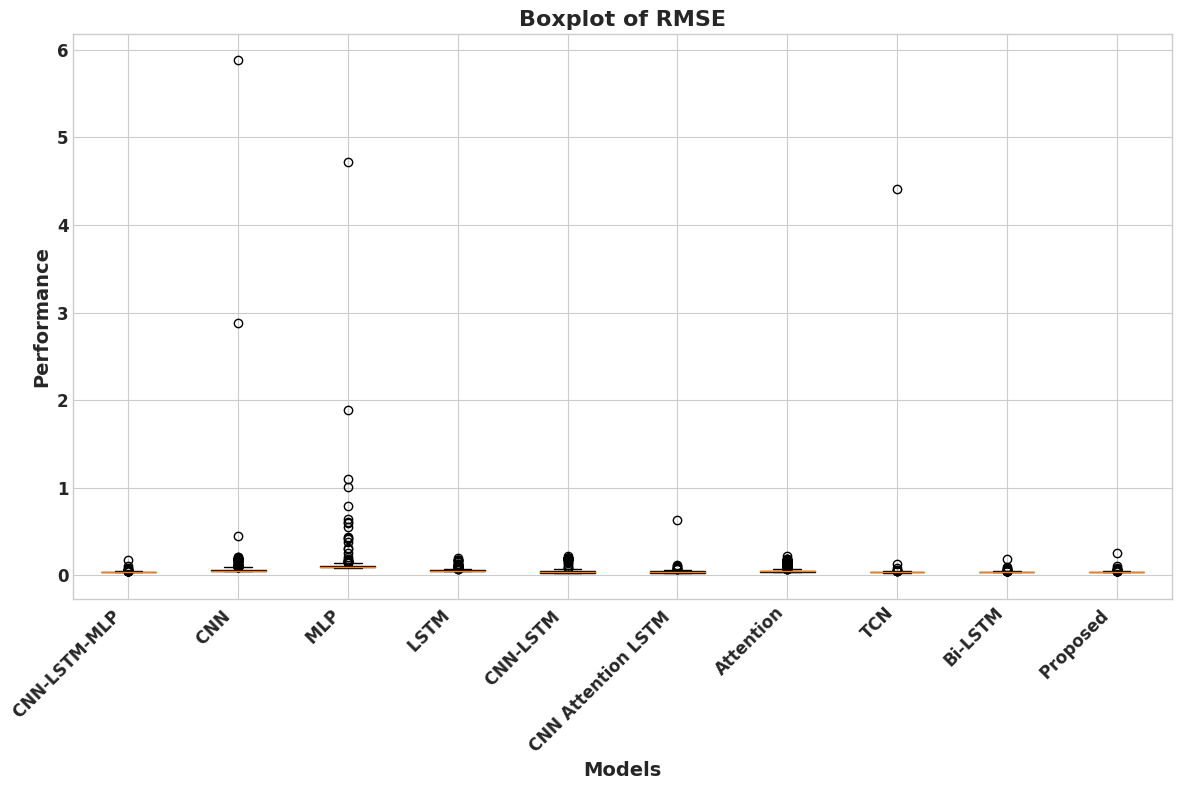

In [87]:
import matplotlib.pyplot as plt
import numpy as np


# Combine the data into a list
all_data = [r2_history_cnn_lstm_mlp, r2_history_cnn, r2_history_mlp, r2_history_lstm,r2_history_cnn_lstm,r2_history_cnn_a_lstm,r2_history_attention,r2_history_tcn,r2_history_esn, r2_history_proposed]

# Define colors for each box
box_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink', 'blue', 'purple', 'orange', 'teal', 'gray']

# Create a boxplot with filled colors
plt.figure(figsize=(12, 8))  # Set the figure size
boxplot = plt.boxplot(all_data, labels=['CNN-LSTM-MLP ',' CNN ', ' MLP ', ' LSTM ',' CNN-LSTM ','CNN Attention LSTM ','Attention','TCN','Bi-LSTM', ' Proposed '], patch_artist=True)

# Assign colors to the boxes
for box, color in zip(boxplot['boxes'], box_colors):
    box.set_facecolor(color)

# Add labels and title with controlled font sizes
plt.xlabel('Models', weight='bold', fontsize=14)
plt.ylabel('Performance', weight='bold', fontsize=14)
plt.title('Boxplot of RMSE', weight='bold', fontsize=16)

# Set the x-axis tick labels with rotation and font size
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)  # Set the y-axis tick labels font size

plt.tight_layout()  # Adjust layout to make room for x-labels
plt.show()

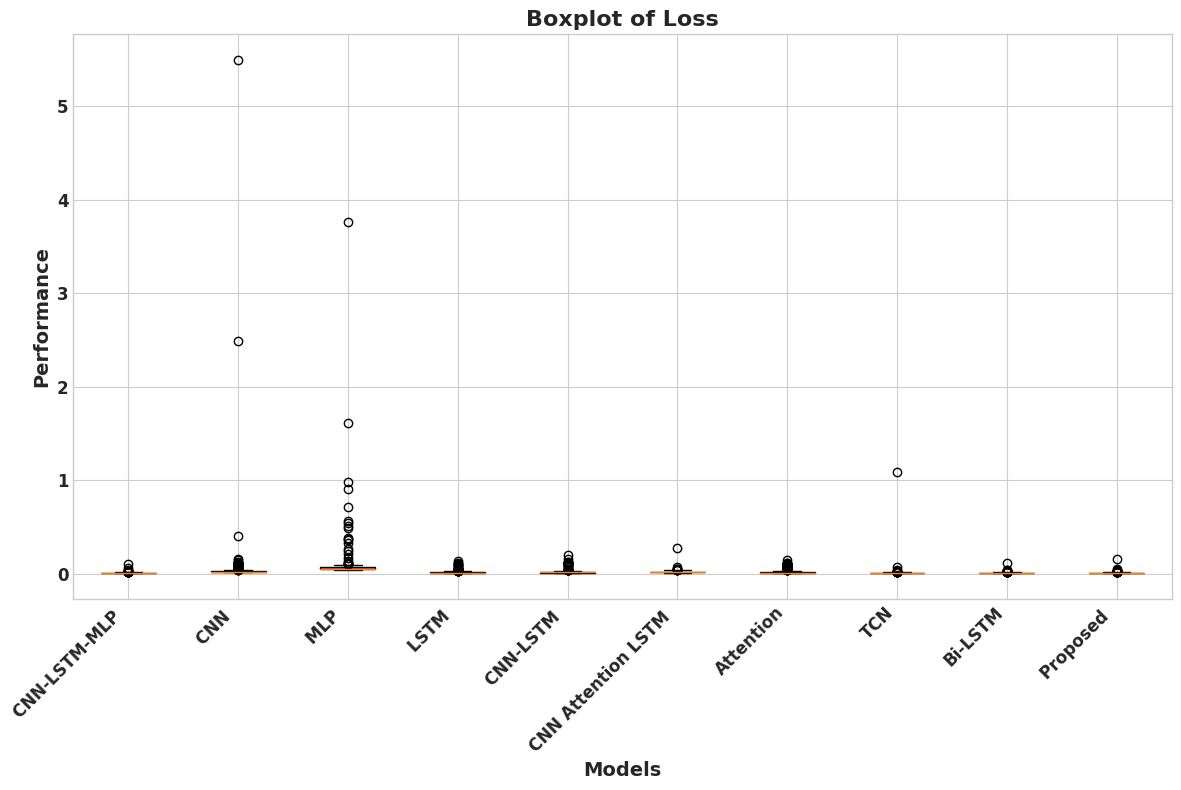

In [88]:
import matplotlib.pyplot as plt
import numpy as np


# Combine the data into a list
all_data = [loss_history_cnn_lstm_mlp, loss_history_cnn, loss_history_mlp, loss_history_lstm,loss_history_cnn_lstm,loss_history_cnn_a_lstm,loss_history_attention,loss_history_tcn,loss_history_esn, loss_history_proposed]

plt.figure(figsize=(12, 8))  # Set the figure size


# Create a boxplot with filled colors
boxplot = plt.boxplot(all_data, labels=['CNN-LSTM-MLP ',' CNN ', ' MLP ', ' LSTM ',' CNN-LSTM ','CNN Attention LSTM ','Attention','TCN','Bi-LSTM', ' Proposed '], patch_artist=True)


# Assign colors to the boxes
for box, color in zip(boxplot['boxes'], box_colors):
    box.set_facecolor(color)

# Add labels and title with controlled font sizes
plt.xlabel('Models', weight='bold', fontsize=14)
plt.ylabel('Performance', weight='bold', fontsize=14)
plt.title('Boxplot of Loss', weight='bold', fontsize=16)

# Set the x-axis tick labels with rotation and font size
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)  # Set the y-axis tick labels font size

plt.tight_layout()  # Adjust layout to make room for x-labels
plt.show()